In [11]:
import pandas as pd
from pickle import load
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## info.csv불러오기

In [12]:
info = pd.read_csv('info.csv')
info.head(5)

,model_name,tag_name,description,threshold
0,vae_group2_turbine_press2,3370-02-EBB08,PRESS RUNNER WITH DISCH RING,0.374463
1,vae_group2_turbine_press2,3370-02-AI109,PENSTOCK PRESS-1,0.603271
2,vae_group2_turbine_press2,3370-02-AI153,PRESSS OF DRAFT TUBE,0.341045
3,vae_group2_turbine_press2,3370-02-AI156,PRESS IN RUNNER & DISCH RING,0.366236
4,vae_group2_turbine_press2,3370-02-AI110,PENSTOCK PRESS-2,0.606230


## 모델 및 스케일러 불러오기

In [13]:
for i in info['model_name'].unique():
    print(i)

vae_group2_turbine_press2
vae_group2_ss_temp
vae_group2_ss_press1_
vae_group1_turbine_press2
vae_group1_turbine_oil_
vae_group1_turbine_bearing2
vae_group1_temp_concat
vae_group1_ss_press1_
vae_group1_cwp_press


In [15]:
models = {}
scalers = {}
for i in info['model_name'].unique():
    model_name_upper = i.upper()  # 모델 이름을 대문자로 변환
    models[model_name_upper] = tf.keras.models.load_model(f"Model_Data/{model_name_upper}/{model_name_upper}_model.tf")
    scalers[model_name_upper] = load(open(f'Model_Data/{model_name_upper}/{model_name_upper}_scaler.pkl', 'rb'))

## 반복되는 코드 함수로 변환

In [16]:
def load_model_and_scaler(model_name, scalers):
    """모델과 스케일러를 불러오기"""
    model = models[model_name]
    scaler = scalers[model_name]
    return model, scaler

def preprocess_data(data, scaler, seq_len, col_len):
    """데이터 scailing"""
    scaled_data = scaler.transform(data.values)
    num_samples = len(scaled_data) // seq_len  
    reshaped_data = scaled_data[:num_samples * seq_len].reshape(num_samples, seq_len, col_len)  # -1로 채널 수 자동 계산
    return reshaped_data

def inverse_transform_predictions(predictions, scaler):
    """scaler 재변환"""
    inverse_predictions = scaler.inverse_transform(predictions.reshape(-1, predictions.shape[-1]))
    return inverse_predictions

def calculate_index(result, threshold):
    """index 계산"""
    result['res'] = abs(result[result.columns[0]] - result[result.columns[1]])
    result['index'] = 1 - (result['res'] / threshold) * 0.3
    result['index_average'] = result['index'].rolling(window=8).mean()
    result['index_average'] = round(result['index_average'].where(result.index >= result.index[7], other=None) * 100, 2)
    result['index_average'].fillna(100,inplace=True) #최초시작되는 7개는 계산이 안되기에 100으로 채우기
    result['alarm'] = result['index_average'] <= 70
    return result

## 데이터 변환테스트

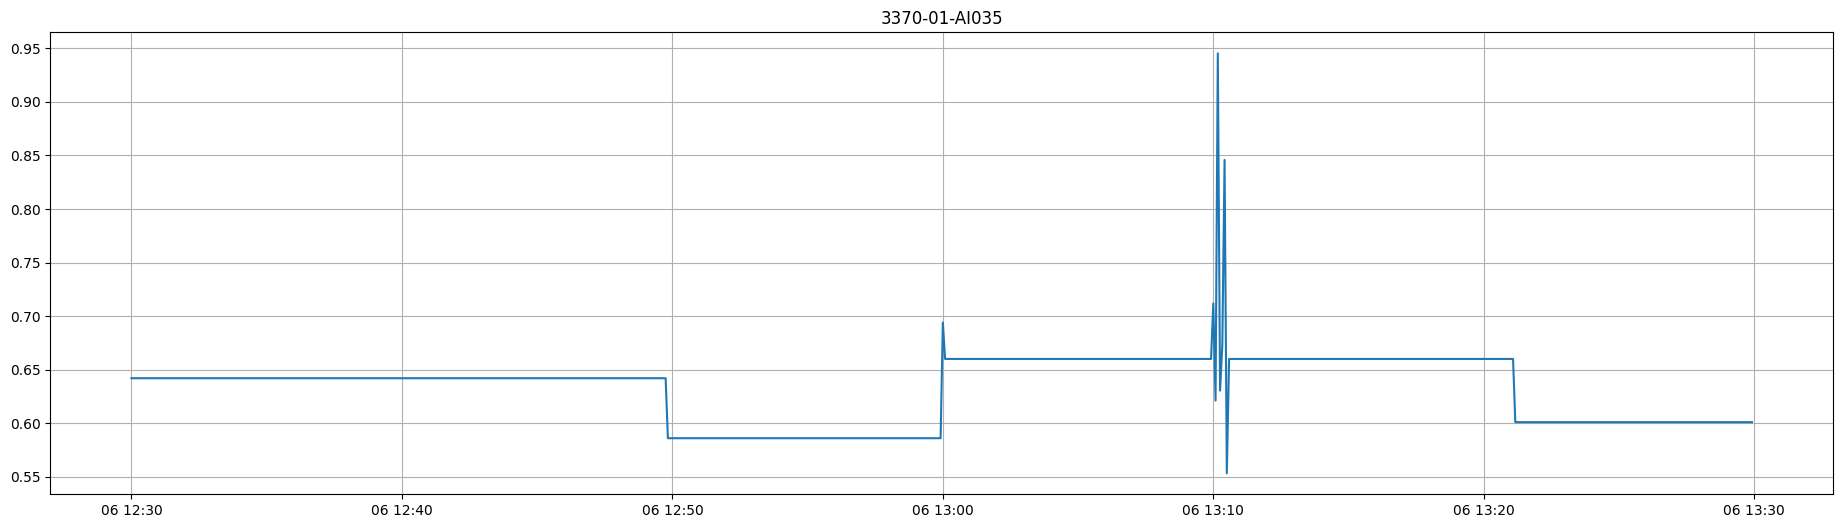

In [209]:

np.random.seed(5)
df[test_column].loc['2024-08-06 13:10:00':'2024-08-06 13:10:25'] += np.random.normal(loc=0, scale=threshold, size=df[test_column].loc['2024-08-06 13:10:00':'2024-08-06 13:10:25'].shape[0])

fixed_value = threshold * 2  # 예: 고정된 값
df[test_column].loc['2024-08-06 13:10:00':'2024-08-06 13:10:25'] += fixed_value

time_indices = np.arange(df[test_column].loc['2024-08-06 13:10:00':'2024-08-06 13:10:25'].shape[0])
frequency = 5  # 주기를 조절하는 값 (높을수록 빠른 변화)
df[test_column].loc['2024-08-06 13:10:00':'2024-08-06 13:10:25'] += np.sin(frequency * time_indices) * threshold*2

selected_data_1 = VAE_GROUP1_CWP_PRESS.loc['2024-08-06 13:09:55':'2024-08-06 13:10:30']
increment_values_1 = np.sqrt(np.linspace(0, 1, len(selected_data_1))) * 0.15
VAE_GROUP1_CWP_PRESS.loc['2024-08-06 13:09:55':'2024-08-06 13:10:30', test_column] = selected_data_1[test_column].values + increment_values_1

#### 시료1 VAE_GROUP1_CWP_PRESS(3370-01-AI098 정상데이터)

In [129]:
# 데이터 불러오기기
VAE_GROUP1_CWP_PRESS = pd.read_csv('sim/VAE_GROUP1_CWP_PRESS/VAE_GROUP1_CWP_PRESS_normal.csv', parse_dates=['Timestamp'], index_col='Timestamp')

#테스트 순서, 사용 column지정
test_num = 1
test_column = '3370-01-AI098'

# 모델 및 스케일러, Threshold불러오기
model_name = 'VAE_GROUP1_CWP_PRESS'
model, scaler = load_model_and_scaler(model_name, scalers)
threshold = info[info['tag_name'] == test_column]['threshold'].values[0]

In [118]:
# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_CWP_PRESS, scaler, 8, VAE_GROUP1_CWP_PRESS.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_CWP_PRESS.columns])
predicted_df.index = VAE_GROUP1_CWP_PRESS.index

# 결과 계산
result = pd.concat([VAE_GROUP1_CWP_PRESS[test_column], predicted_df[f'{test_column}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/test{test_num}_{model_name}_result.csv')

3/3 [==============================] - 0s 2ms/step


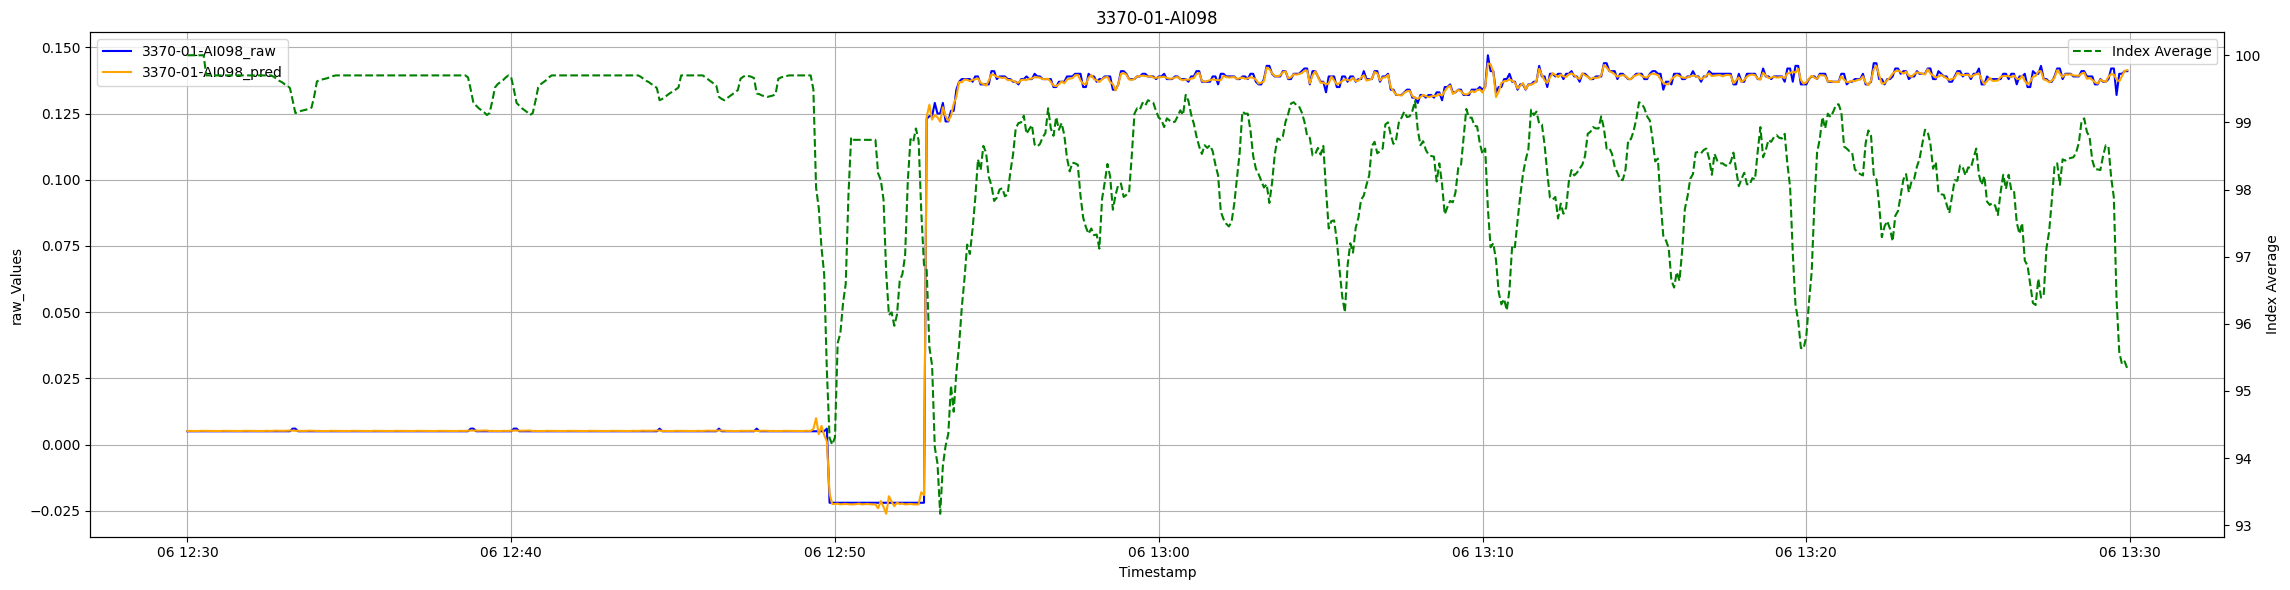

In [119]:
plt.figure(figsize=(23,6))
plt.plot(result[test_column], label=f'{test_column}_raw', color='blue')
plt.plot(result[f'{test_column}_pred'], label=f'{test_column}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_column)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')

plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_CWP_PRESS(3370-01-AI098 비정상데이터)

In [121]:
import numpy as np
VAE_GROUP1_CWP_PRESS = pd.read_csv('sim/VAE_GROUP1_CWP_PRESS/VAE_GROUP1_CWP_PRESS_normal.csv', parse_dates=['Timestamp'], index_col='Timestamp')
start_time_1 = '2024-08-06 13:09:55'
end_time_1 = '2024-08-06 13:10:25'
selected_data_1 = VAE_GROUP1_CWP_PRESS.loc[start_time_1:end_time_1]
increment_values_1 = np.sqrt(np.linspace(0, 1, len(selected_data_1))) * 0.15
VAE_GROUP1_CWP_PRESS.loc[start_time_1:end_time_1, '3370-01-AI098'] = selected_data_1['3370-01-AI098'].values + increment_values_1


print(VAE_GROUP1_CWP_PRESS.index.min(), VAE_GROUP1_CWP_PRESS.index.max())
print(VAE_GROUP1_CWP_PRESS.shape)
VAE_GROUP1_CWP_PRESS.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 8)


,3370-01-AI098,3370-01-AI099,3370-01-AI201,3370-01-AI202-1,3370-01-AI202,3370-01-EA5G5,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,,,
2024-08-06 12:30:00,0.005,-0.003,9.251,8.997,9.019,0.784,0,1
2024-08-06 12:30:05,0.005,-0.003,9.251,8.997,9.019,0.784,0,1
2024-08-06 12:30:10,0.005,-0.003,9.251,8.997,9.019,0.784,0,1
2024-08-06 12:30:15,0.005,-0.003,9.251,8.997,9.019,0.784,0,1
2024-08-06 12:30:20,0.005,-0.003,9.251,8.997,9.019,0.784,0,1


In [ ]:
# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_CWP_PRESS, scaler, 8, VAE_GROUP1_CWP_PRESS.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_CWP_PRESS.columns])
predicted_df.index = VAE_GROUP1_CWP_PRESS.index

# 결과 계산
result = pd.concat([VAE_GROUP1_CWP_PRESS[test_column], predicted_df[f'{test_column}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 2ms/step


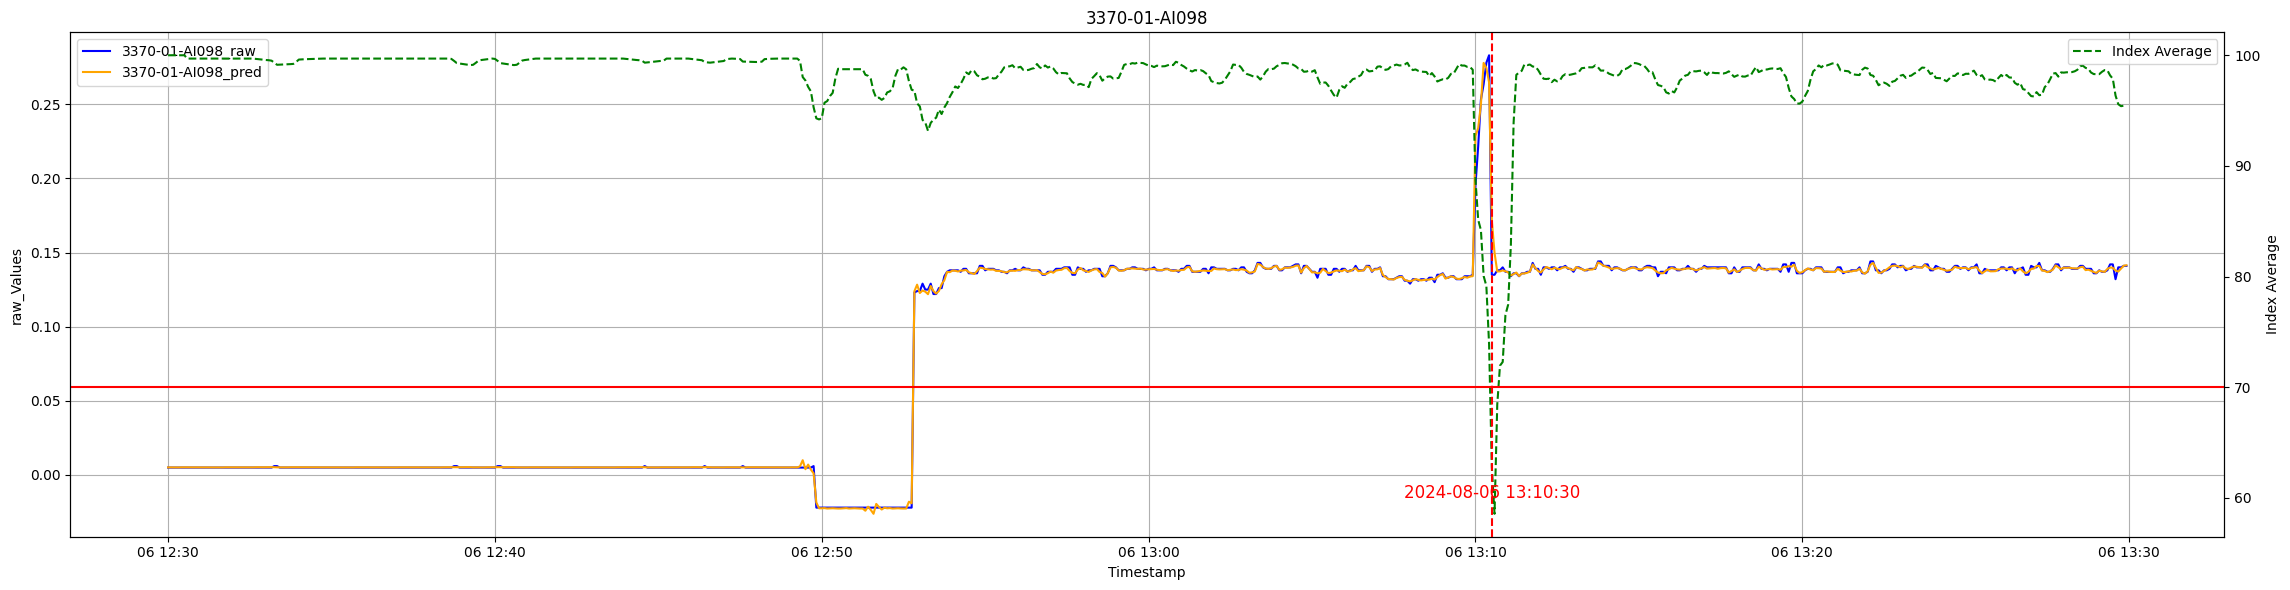

In [110]:
plt.figure(figsize=(23,6))
plt.plot(result[test_column], label=f'{test_column}_raw', color='blue')
plt.plot(result[f'{test_column}_pred'], label=f'{test_column}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_column)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')

plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_SS_PRESS1(3370-01-AI035 정상데이터)

In [ ]:
VAE_GROUP1_SS_PRESS1 = pd.read_csv('sim/VAE_GROUP1_SS_PRESS1/VAE_GROUP1_SS_PRESS1.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_SS_PRESS1.index.min(), VAE_GROUP1_SS_PRESS1.index.max())
print(VAE_GROUP1_SS_PRESS1.shape)
VAE_GROUP1_SS_PRESS1.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 6)


,3370-01-AI035,3370-01-AI036,3370-01-AI037,3370-01-AI145,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,
2024-08-06 12:30:00,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:05,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:10,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:15,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:20,0.642,0.668,0.688,7.749,1,1


In [ ]:
#테스트 순서, 사용 column지정
test_num = 1
column_num = 0
test_tag = VAE_GROUP1_SS_PRESS1.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_SS_PRESS1, scaler, 8, VAE_GROUP1_SS_PRESS1.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_SS_PRESS1.columns])
predicted_df.index = VAE_GROUP1_SS_PRESS1.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_SS_PRESS1[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 26ms/step


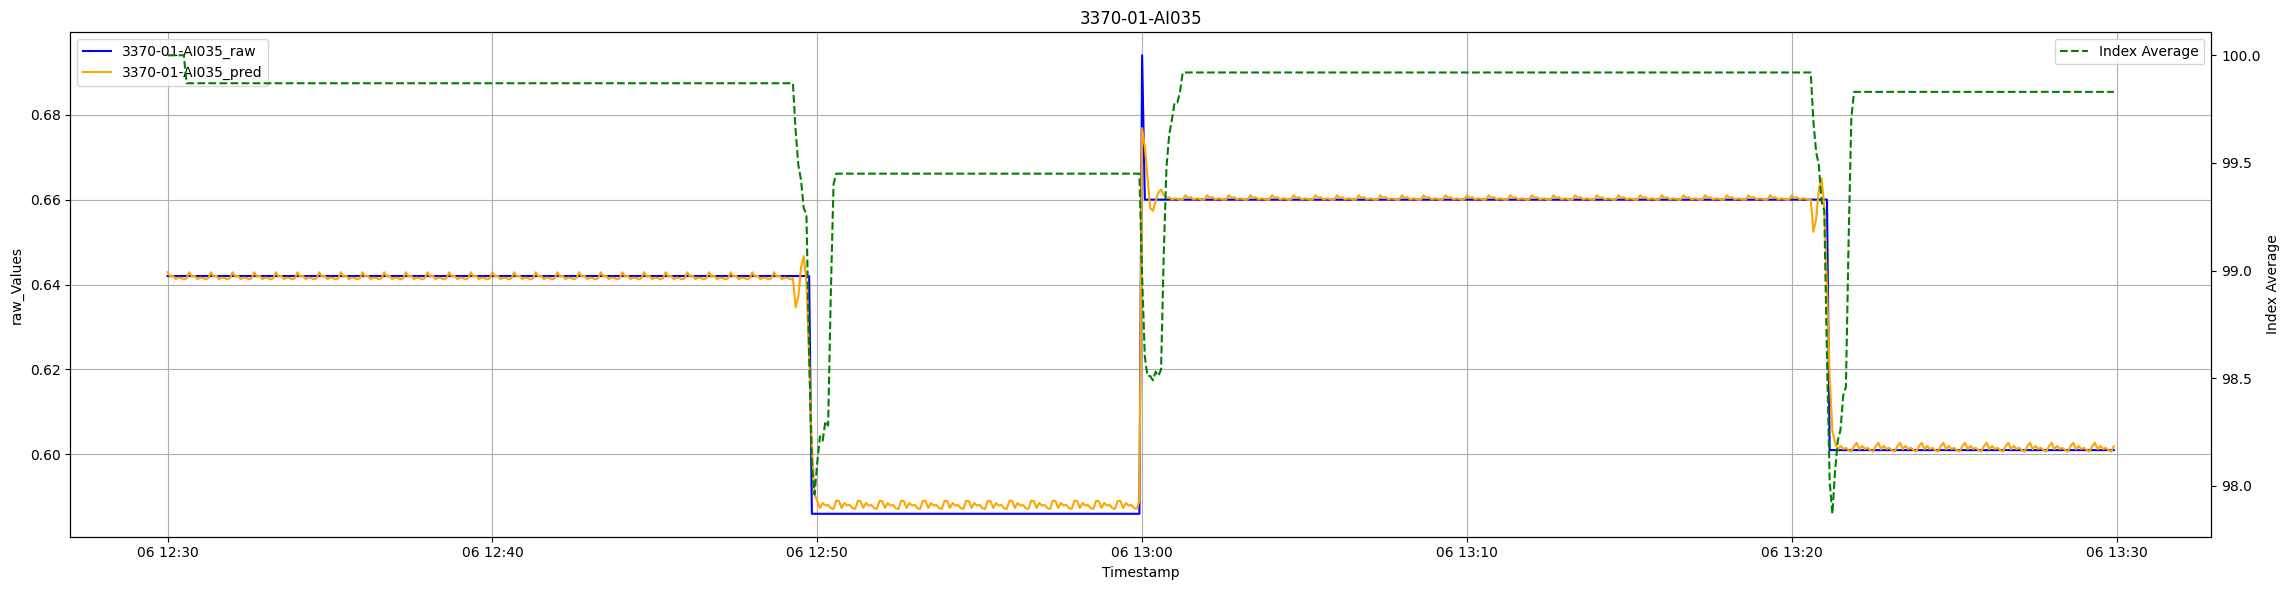

In [ ]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    plt.axvline(result[result['alarm']==True].index[0],color='red', linestyle = '--')
    plt.axhline(70,color='red')
plt.tight_layout()
plt.show()

#### 시료2 VAE_GROUP1_SS_PRESS1(3370-01-AI035 비정상데이터)

In [201]:
import numpy as np
df = pd.read_csv('sim/VAE_GROUP1_SS_PRESS1/VAE_GROUP1_SS_PRESS1.csv', parse_dates=['Timestamp'], index_col='Timestamp')
np.random.seed(1)
df['3370-01-AI035'].loc['2024-08-06 13:10:00':'2024-08-06 13:10:30'] += np.random.normal(loc=0, scale=threshold, size=df['3370-01-AI035'].loc['2024-08-06 13:10:00':'2024-08-06 13:10:30'].shape[0])

print(df.index.min(), df.index.max())
print(df.shape)
df.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 6)


,3370-01-AI035,3370-01-AI036,3370-01-AI037,3370-01-AI145,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,
2024-08-06 12:30:00,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:05,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:10,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:15,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:20,0.642,0.668,0.688,7.749,1,1


In [202]:
#테스트 순서, 사용 column지정
test_num = 2
column_num = 0
test_tag = VAE_GROUP1_SS_PRESS1.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(df, scaler, 8, df.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in df.columns])
predicted_df.index = df.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([df[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 17ms/step


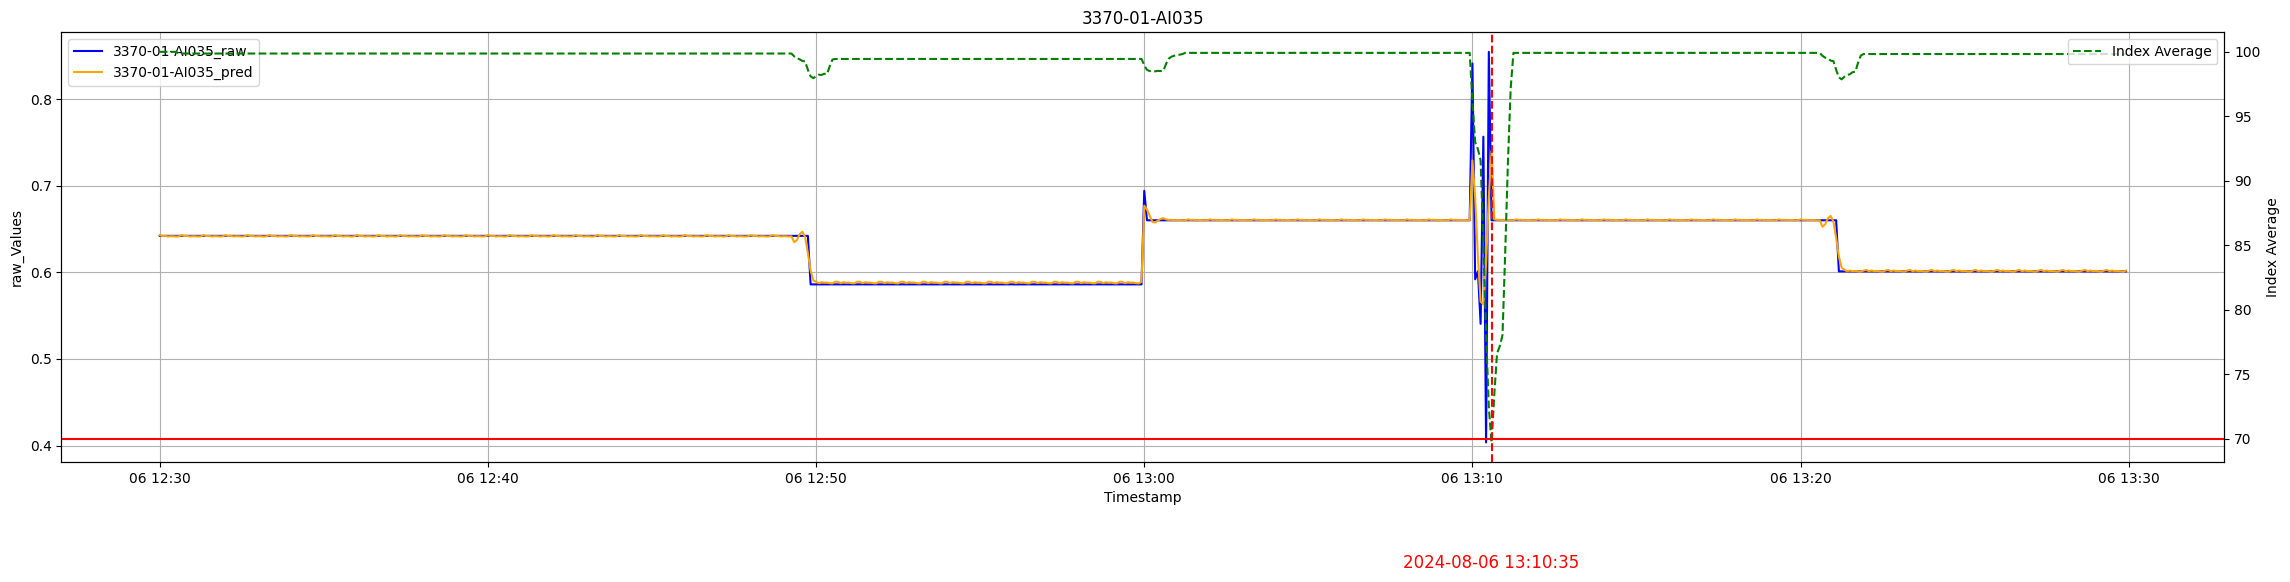

In [203]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')

    
plt.tight_layout()
plt.show()

#### 시료3 VAE_GROUP1_SS_PRESS1(3370-01-AI037 정상데이터)

In [204]:
VAE_GROUP1_SS_PRESS1 = pd.read_csv('sim/VAE_GROUP1_SS_PRESS1/VAE_GROUP1_SS_PRESS1.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_SS_PRESS1.index.min(), VAE_GROUP1_SS_PRESS1.index.max())
print(VAE_GROUP1_SS_PRESS1.shape)
VAE_GROUP1_SS_PRESS1.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 6)


,3370-01-AI035,3370-01-AI036,3370-01-AI037,3370-01-AI145,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,
2024-08-06 12:30:00,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:05,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:10,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:15,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:20,0.642,0.668,0.688,7.749,1,1


In [205]:
#테스트 순서, 사용 column지정
test_num = 2
column_num = 2
test_tag = VAE_GROUP1_SS_PRESS1.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_SS_PRESS1, scaler, 8, VAE_GROUP1_SS_PRESS1.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_SS_PRESS1.columns])
predicted_df.index = VAE_GROUP1_SS_PRESS1.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_SS_PRESS1[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 25ms/step


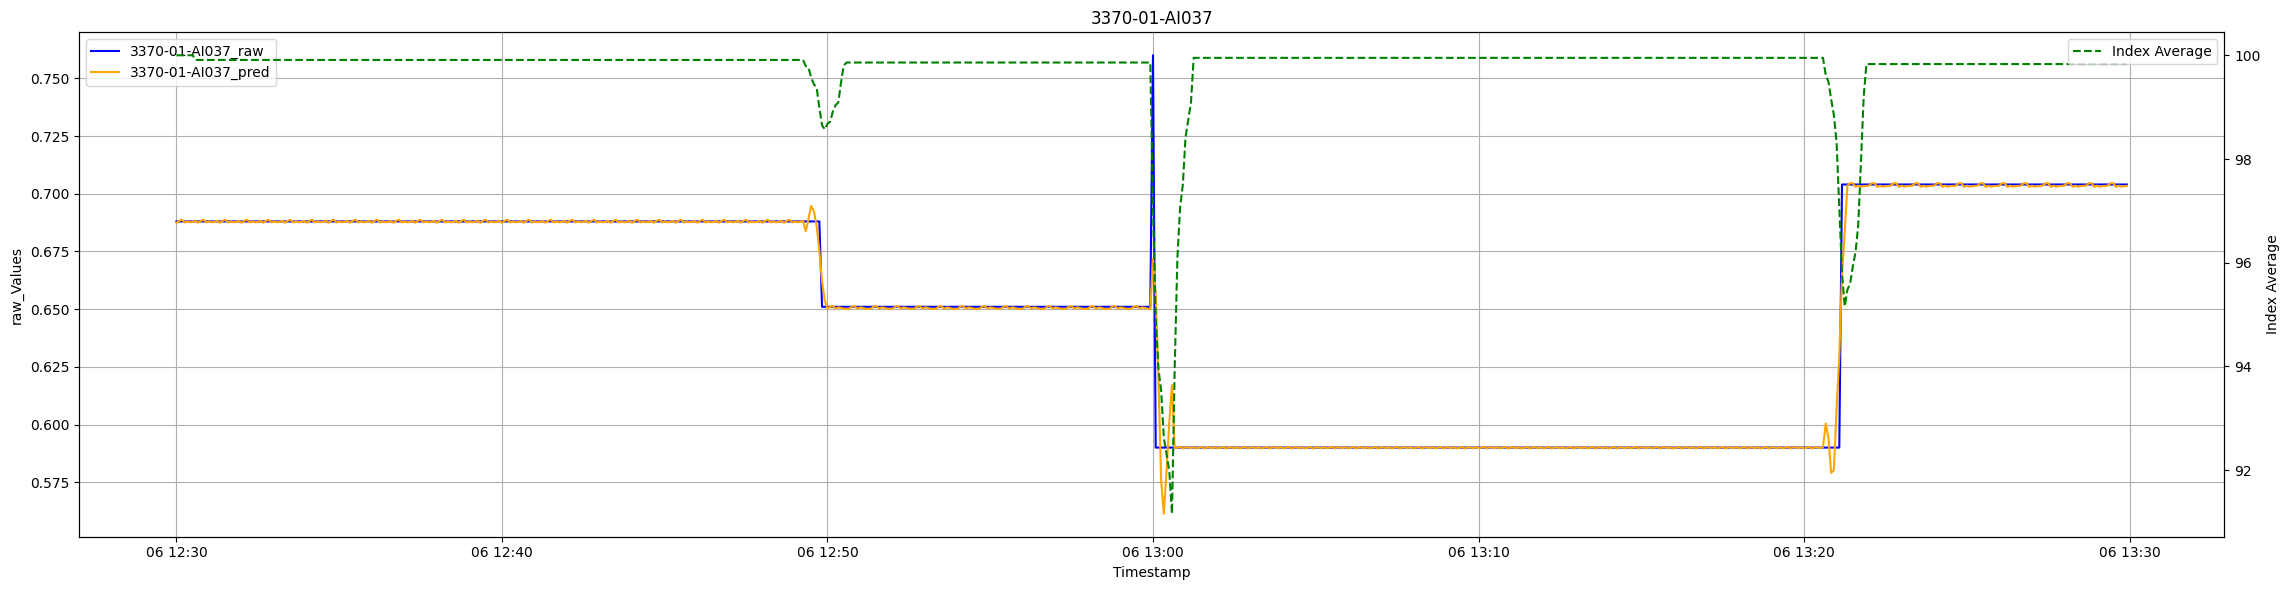

In [79]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료4 VAE_GROUP1_SS_PRESS1(3370-01-AI037 비정상데이터)

In [235]:
import numpy as np
df = pd.read_csv('sim/VAE_GROUP1_SS_PRESS1/VAE_GROUP1_SS_PRESS1.csv', parse_dates=['Timestamp'], index_col='Timestamp')
np.random.seed(6)
df['3370-01-AI037'].loc['2024-08-06 13:10:00':'2024-08-06 13:10:30'] += np.random.normal(loc=0, scale=threshold, size=df['3370-01-AI035'].loc['2024-08-06 13:10:00':'2024-08-06 13:10:30'].shape[0])

print(df.index.min(), df.index.max())
print(df.shape)
df.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 6)


,3370-01-AI035,3370-01-AI036,3370-01-AI037,3370-01-AI145,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,
2024-08-06 12:30:00,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:05,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:10,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:15,0.642,0.668,0.688,7.749,1,1
2024-08-06 12:30:20,0.642,0.668,0.688,7.749,1,1


In [236]:
#테스트 순서, 사용 column지정
test_num = 3
column_num = 2
test_tag = df.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(df, scaler, 8, df.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in df.columns])
predicted_df.index = df.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([df[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 67ms/step


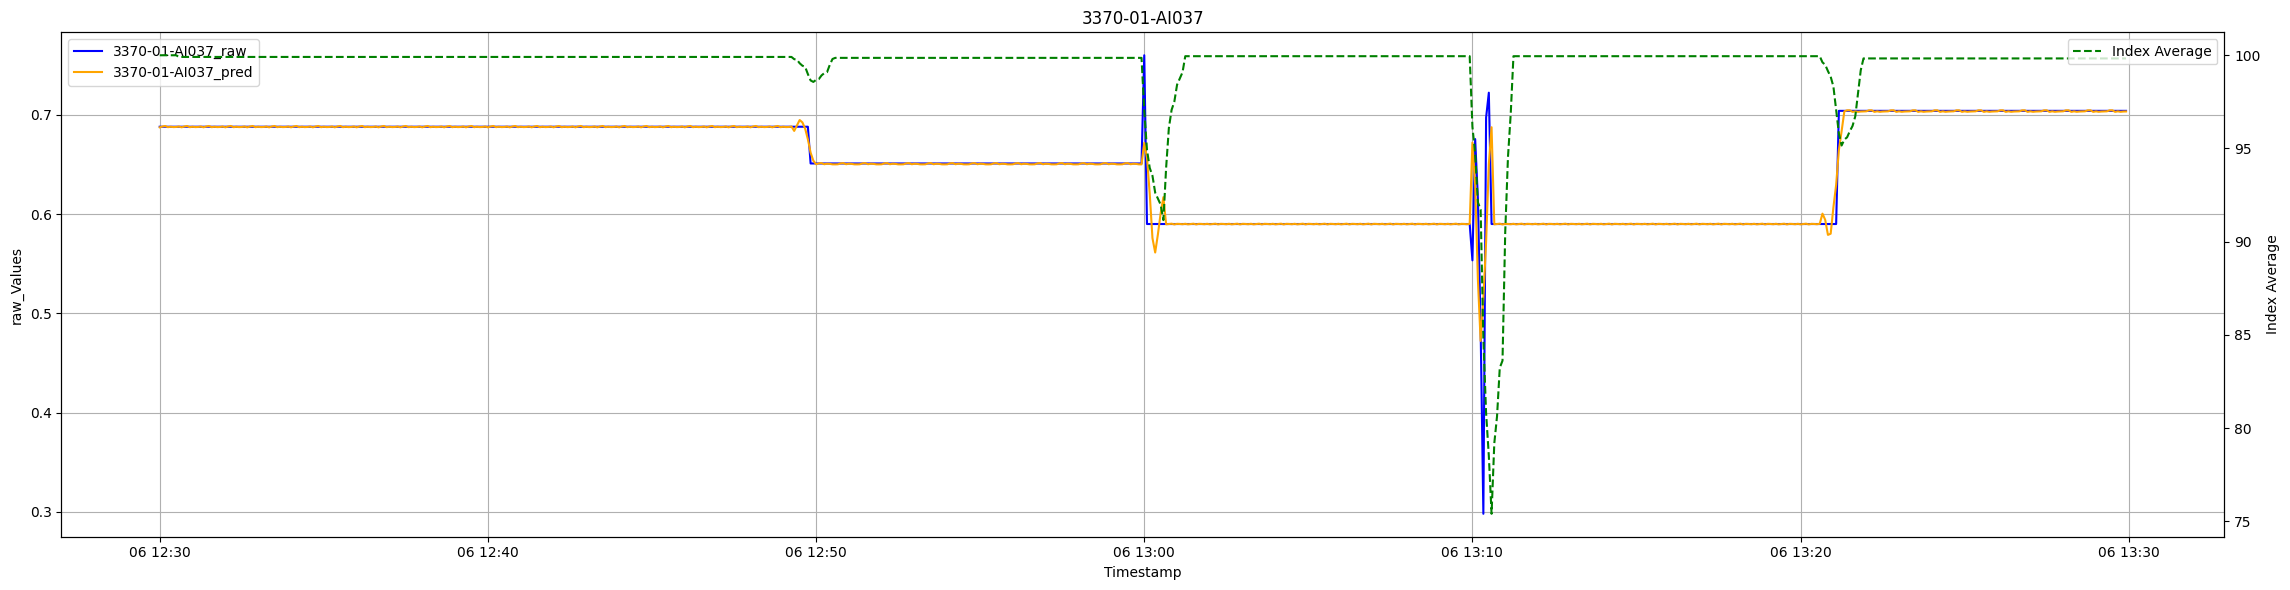

In [237]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_TEMP_CONCAT

In [80]:
VAE_GROUP1_TEMP_CONCAT = pd.read_csv('sim/VAE_GROUP1_TEMP_CONCAT/VAE_GROUP1_TEMP_CONCAT.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_TEMP_CONCAT.index.min(), VAE_GROUP1_TEMP_CONCAT.index.max())
print(VAE_GROUP1_TEMP_CONCAT.shape)
VAE_GROUP1_TEMP_CONCAT.head(5)

2024-08-06 06:00:00 2024-08-06 07:59:55
(1440, 7)


,3370-01-AI081,3370-01-AI082,3370-01-AI083,3370-01-AI084,3370-01-AI085,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,,
2024-08-06 06:00:00,61.511,57.055,57.946,55.02,63.422,0.0,0.0
2024-08-06 06:00:05,61.511,57.055,57.946,55.02,63.422,0.0,0.0
2024-08-06 06:00:10,61.511,57.055,57.946,55.02,63.422,0.0,0.0
2024-08-06 06:00:15,61.511,57.055,57.946,55.02,63.422,0.0,0.0
2024-08-06 06:00:20,61.511,57.055,57.946,55.02,63.422,0.0,0.0


In [81]:
#테스트 순서, 사용 column지정
test_num = 3
column_num = 2
test_tag = VAE_GROUP1_TEMP_CONCAT.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TEMP_CONCAT'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TEMP_CONCAT, scaler, 8, VAE_GROUP1_TEMP_CONCAT.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TEMP_CONCAT.columns])
predicted_df.index = VAE_GROUP1_TEMP_CONCAT.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TEMP_CONCAT[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

6/6 [==============================] - 0s 26ms/step


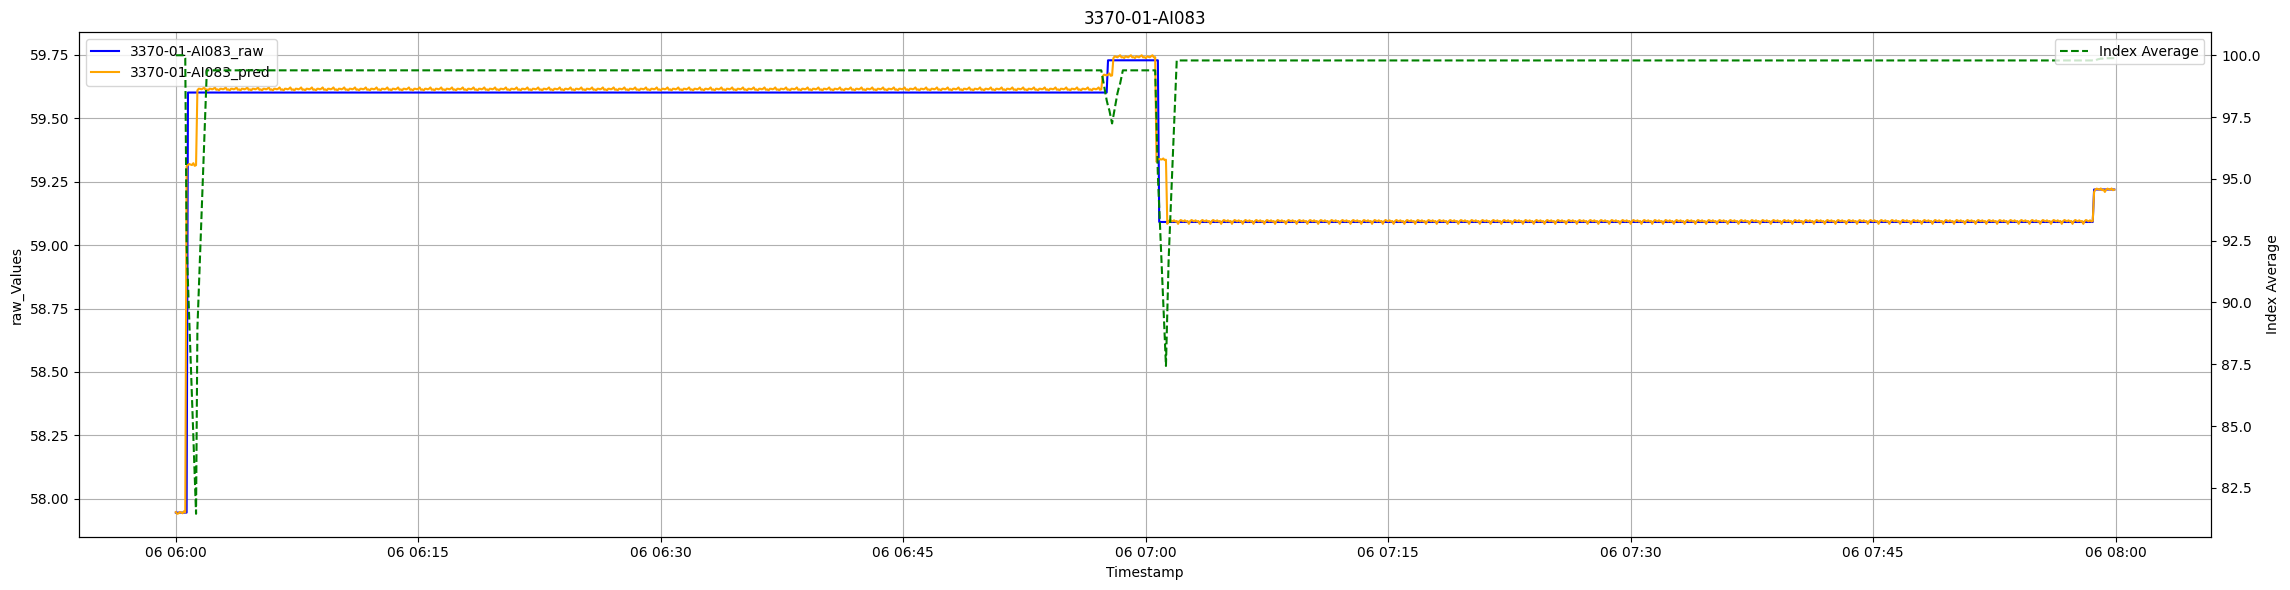

In [82]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [83]:
#테스트 순서, 사용 column지정
test_num = 4
column_num = 3
test_tag = VAE_GROUP1_TEMP_CONCAT.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TEMP_CONCAT'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TEMP_CONCAT, scaler, 8, VAE_GROUP1_TEMP_CONCAT.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TEMP_CONCAT.columns])
predicted_df.index = VAE_GROUP1_TEMP_CONCAT.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TEMP_CONCAT[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

6/6 [==============================] - 0s 15ms/step


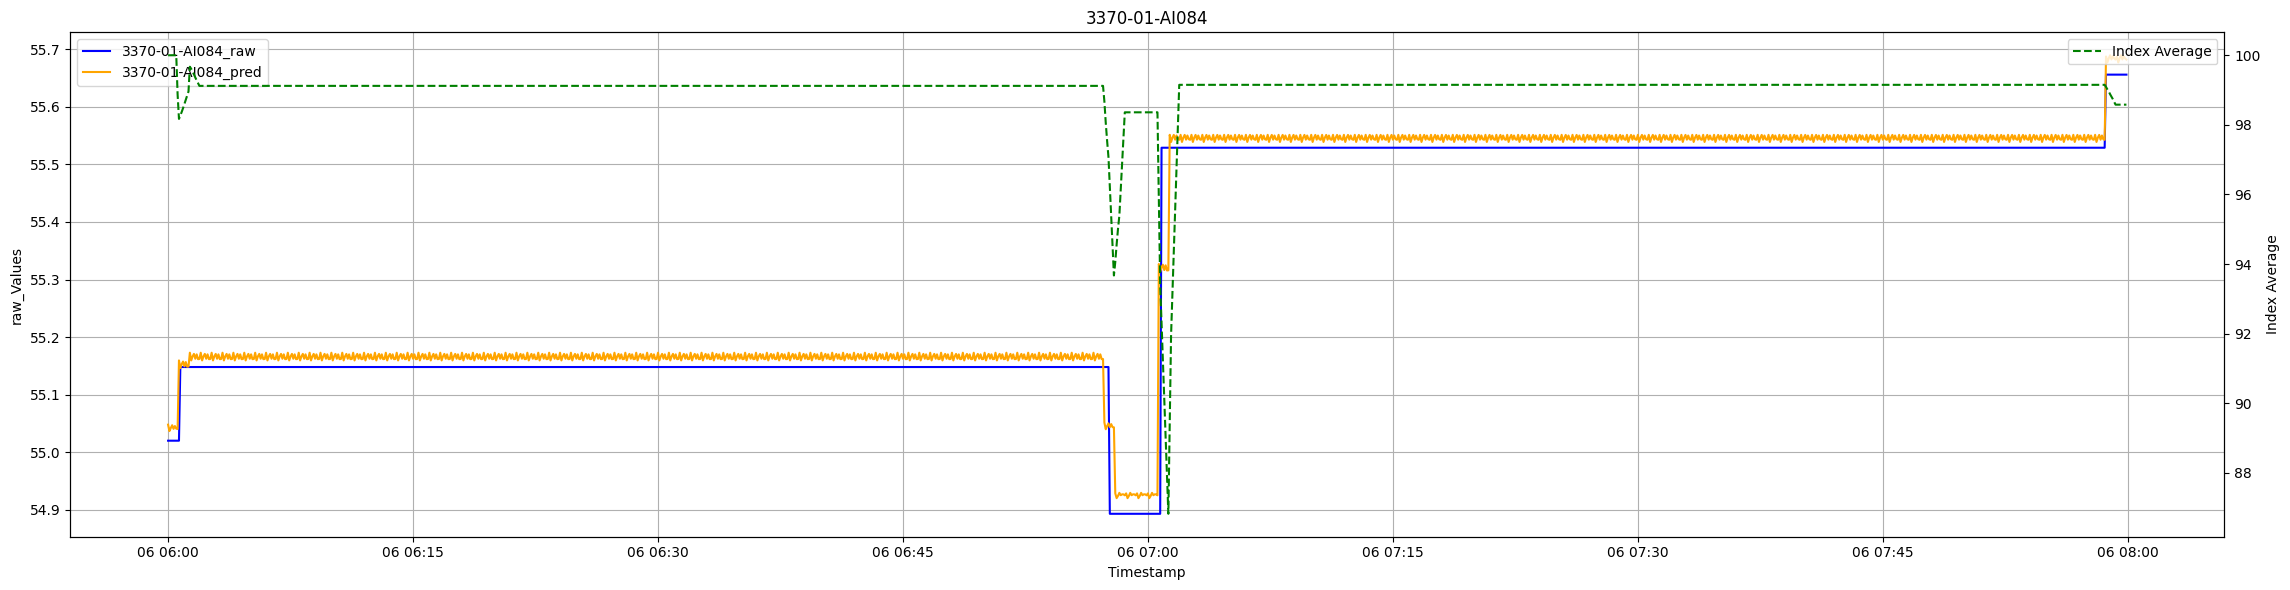

In [84]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_TURBINE_BEARING2

In [85]:
VAE_GROUP1_TURBINE_BEARING2 = pd.read_csv('sim/VAE_GROUP1_TURBINE_BEARING2/VAE_GROUP1_TURBINE_BEARING2.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_TURBINE_BEARING2.index.min(), VAE_GROUP1_TURBINE_BEARING2.index.max())
print(VAE_GROUP1_TURBINE_BEARING2.shape)
VAE_GROUP1_TURBINE_BEARING2.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 5)


,3370-01-TBNBRG-VIB-X,3370-01-TBNBRG-VIB-Y,3370-01-CAVITATION,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,
2024-08-06 12:30:00,79.4,97.63,0.48,1.0,1.0
2024-08-06 12:30:05,79.4,97.63,0.48,1.0,1.0
2024-08-06 12:30:10,79.4,97.63,0.48,1.0,1.0
2024-08-06 12:30:15,79.4,97.63,0.48,1.0,1.0
2024-08-06 12:30:20,79.4,97.63,0.48,1.0,1.0


In [86]:
#테스트 순서, 사용 column지정
test_num = 5
column_num = 0
test_tag = VAE_GROUP1_TURBINE_BEARING2.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_BEARING2'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_BEARING2, scaler, 8, VAE_GROUP1_TURBINE_BEARING2.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_BEARING2.columns])
predicted_df.index = VAE_GROUP1_TURBINE_BEARING2.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_BEARING2[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 18ms/step


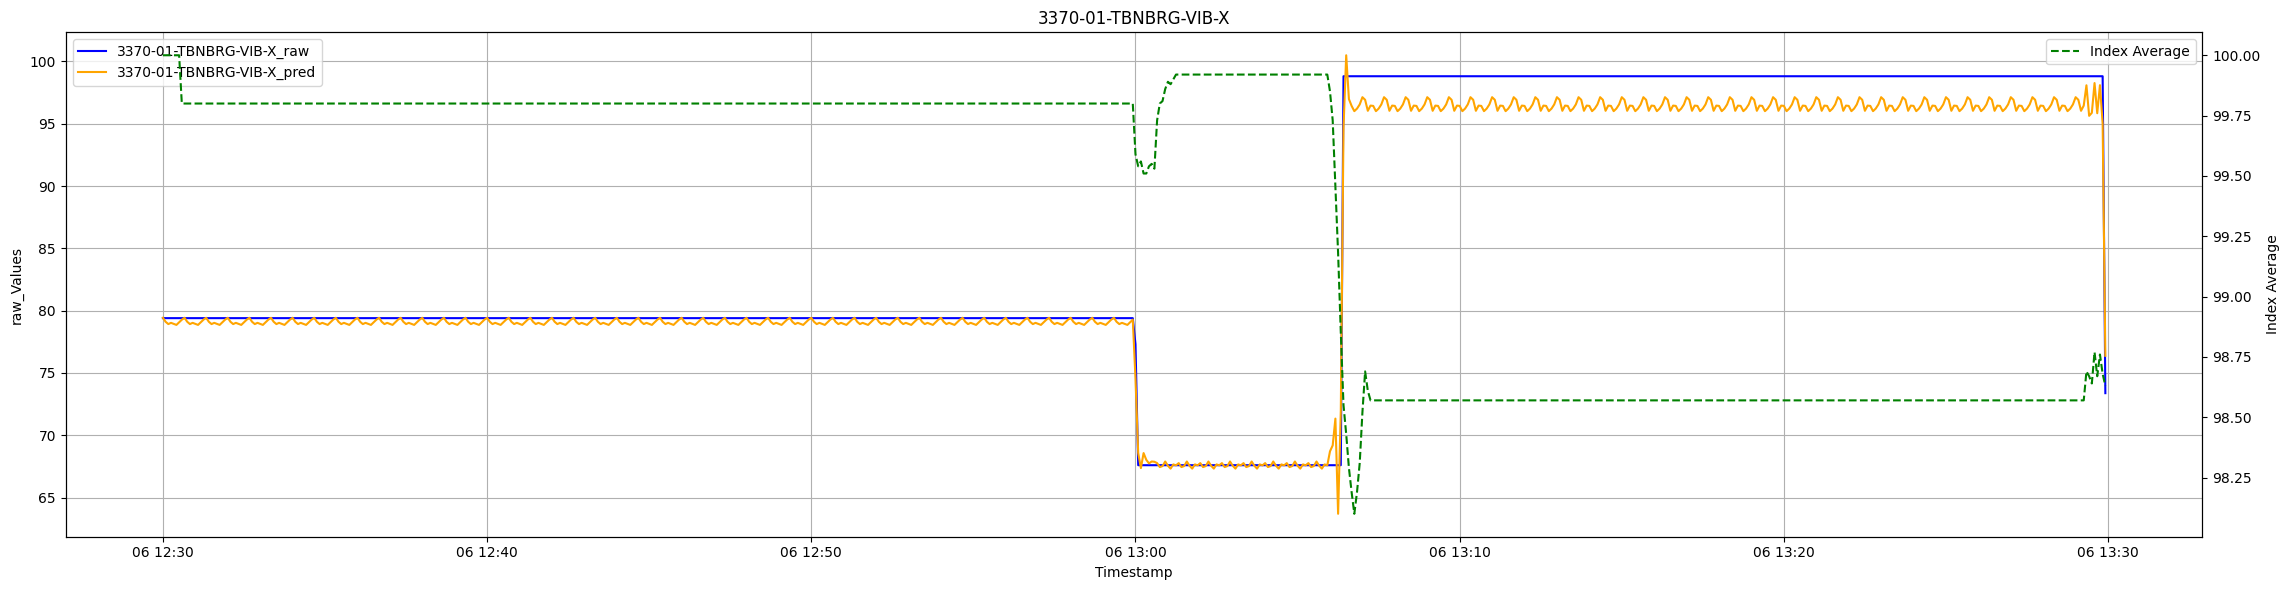

In [87]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [88]:
#테스트 순서, 사용 column지정
test_num = 6
column_num = 1
test_tag = VAE_GROUP1_TURBINE_BEARING2.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_BEARING2'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_BEARING2, scaler, 8, VAE_GROUP1_TURBINE_BEARING2.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_BEARING2.columns])
predicted_df.index = VAE_GROUP1_TURBINE_BEARING2.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_BEARING2[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 17ms/step


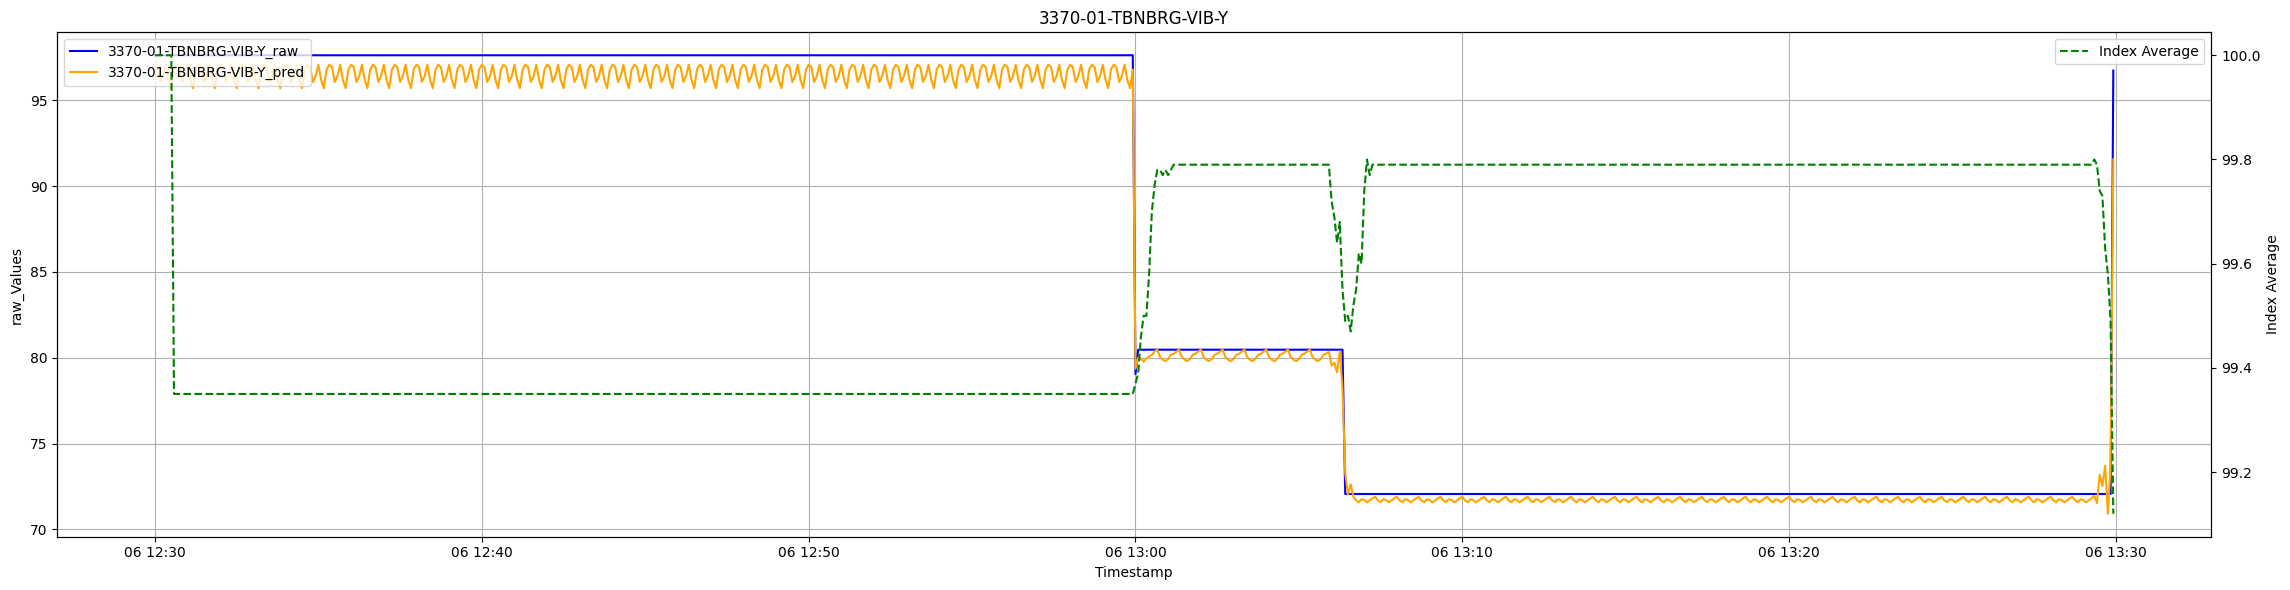

In [89]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_TURBINE_PRESS2

In [90]:
VAE_GROUP1_TURBINE_PRESS2 = pd.read_csv('sim/VAE_GROUP1_TURBINE_PRESS2/VAE_GROUP1_TURBINE_PRESS2.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_TURBINE_PRESS2.index.min(), VAE_GROUP1_TURBINE_PRESS2.index.max())
print(VAE_GROUP1_TURBINE_PRESS2.shape)
VAE_GROUP1_TURBINE_PRESS2.head(5)

2024-08-06 06:00:00 2024-08-06 07:59:55
(1440, 7)


,3370-01-AI156,3370-01-AI153,3370-01-AI109,3370-01-AI110,3370-01-EBB08,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,,
2024-08-06 06:00:00,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:05,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:10,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:15,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:20,9.202,8.023,51.759,53.018,9.202,0.0,0.0


In [91]:
#테스트 순서, 사용 column지정
test_num = 7
column_num = 2
test_tag = VAE_GROUP1_TURBINE_PRESS2.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_PRESS2'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_PRESS2, scaler, 8, VAE_GROUP1_TURBINE_PRESS2.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_PRESS2.columns])
predicted_df.index = VAE_GROUP1_TURBINE_PRESS2.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_PRESS2[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

6/6 [==============================] - 0s 24ms/step


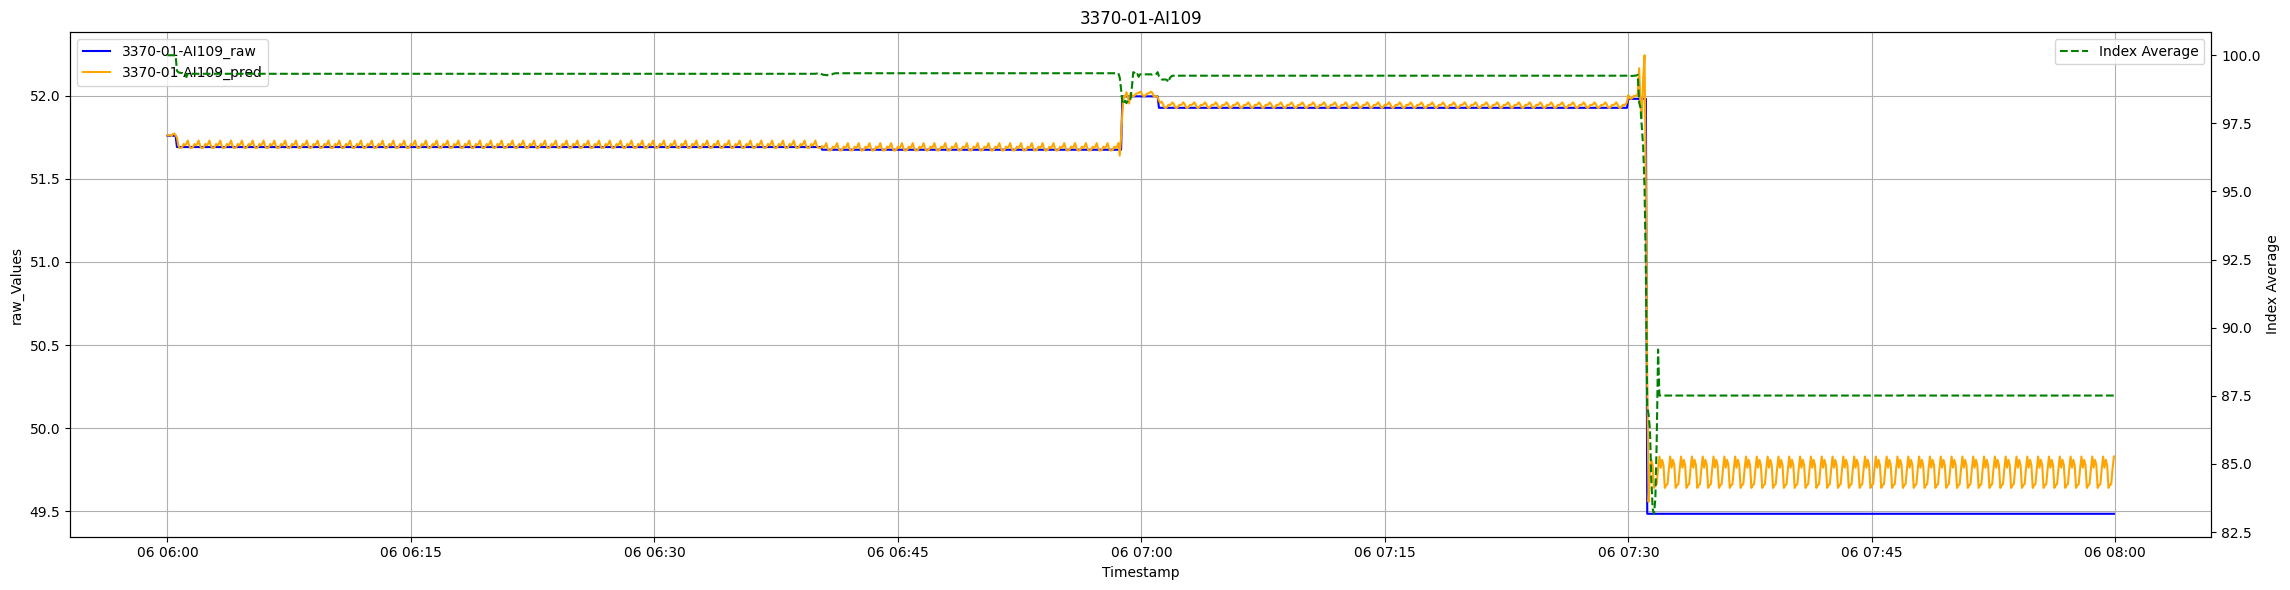

In [92]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [93]:
#테스트 순서, 사용 column지정
test_num = 8
column_num = 3
test_tag = VAE_GROUP1_TURBINE_PRESS2.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_PRESS2'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_PRESS2, scaler, 8, VAE_GROUP1_TURBINE_PRESS2.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_PRESS2.columns])
predicted_df.index = VAE_GROUP1_TURBINE_PRESS2.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_PRESS2[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

6/6 [==============================] - 0s 12ms/step


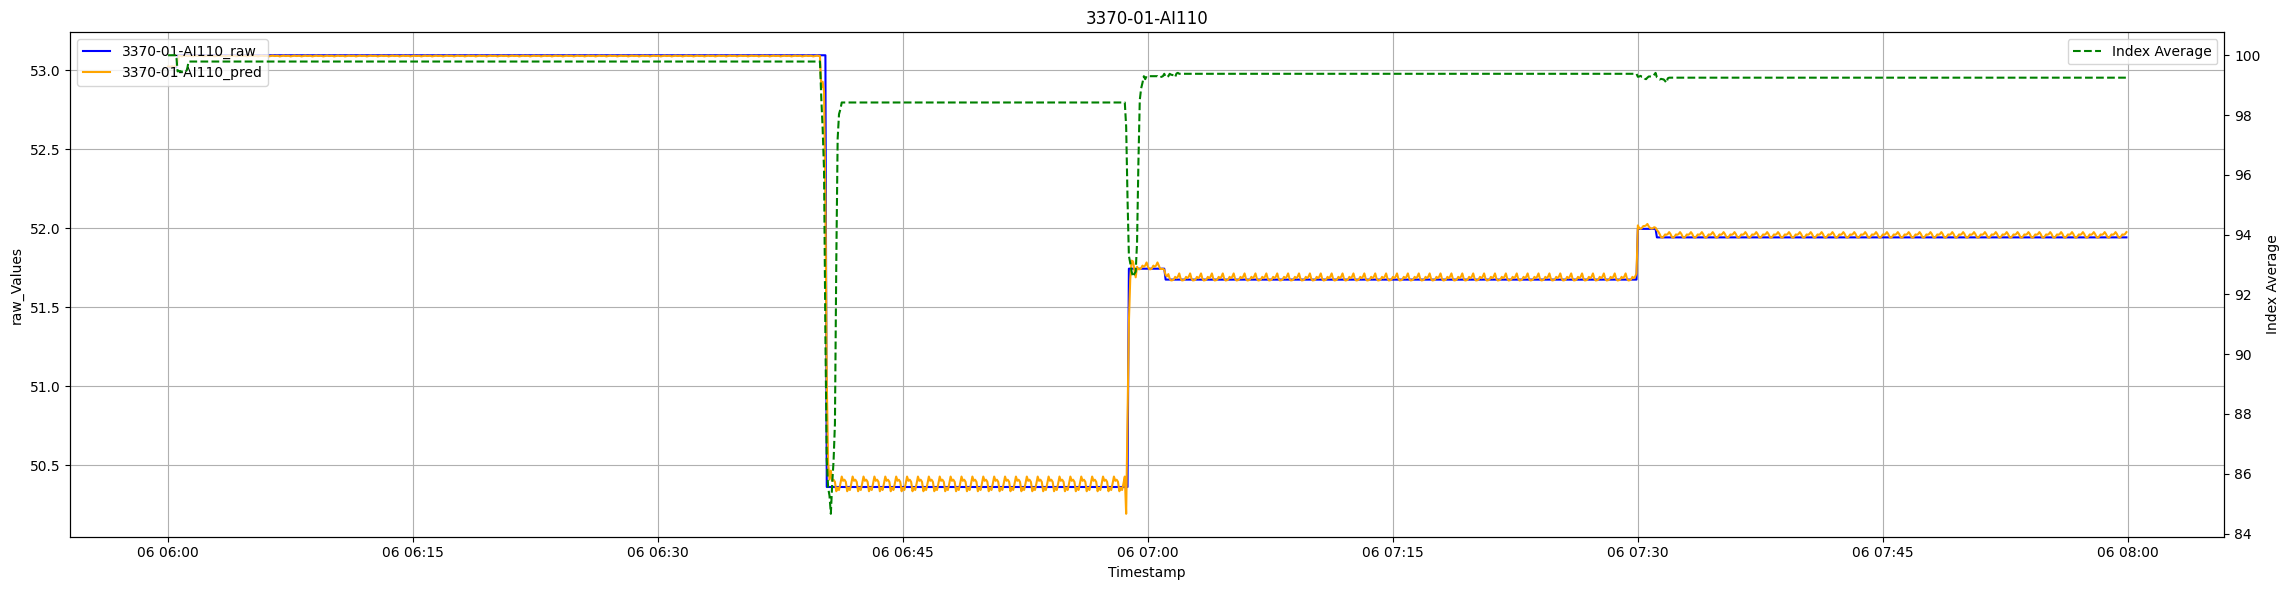

In [94]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_TURBINE_OIL

In [95]:
VAE_GROUP1_TURBINE_OIL = pd.read_csv('sim/VAE_GROUP1_TURBINE_OIL/VAE_GROUP1_TURBINE_OIL.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_TURBINE_OIL.index.min(), VAE_GROUP1_TURBINE_OIL.index.max())
print(VAE_GROUP1_TURBINE_OIL.shape)
VAE_GROUP1_TURBINE_OIL.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 11)


,3370-01-AI024,3370-01-AI025,3370-01-AI026,3370-01-AI027,3370-01-AI028,3370-01-AI029,3370-01-AI079,3370-01-AI078-1,3370-01-DTGATE-AI002,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,,,,,,
2024-08-06 12:30:00,2.931,-0.124,2.93,2.929,2.889,-0.126,47.908,48.289,19.437,1.0,1.0
2024-08-06 12:30:05,2.931,-0.124,2.93,2.929,2.889,-0.126,47.908,48.289,19.437,1.0,1.0
2024-08-06 12:30:10,2.931,-0.124,2.93,2.929,2.889,-0.126,47.908,48.289,19.437,1.0,1.0
2024-08-06 12:30:15,2.931,-0.124,2.93,2.929,2.889,-0.126,47.908,48.289,19.437,1.0,1.0
2024-08-06 12:30:20,2.931,-0.124,2.93,2.929,2.889,-0.126,47.908,48.289,19.437,1.0,1.0


In [96]:
#테스트 순서, 사용 column지정
test_num = 9
column_num = 0
test_tag = VAE_GROUP1_TURBINE_OIL.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_OIL_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_OIL, scaler, 8, VAE_GROUP1_TURBINE_OIL.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_OIL.columns])
predicted_df.index = VAE_GROUP1_TURBINE_OIL.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_OIL[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 21ms/step


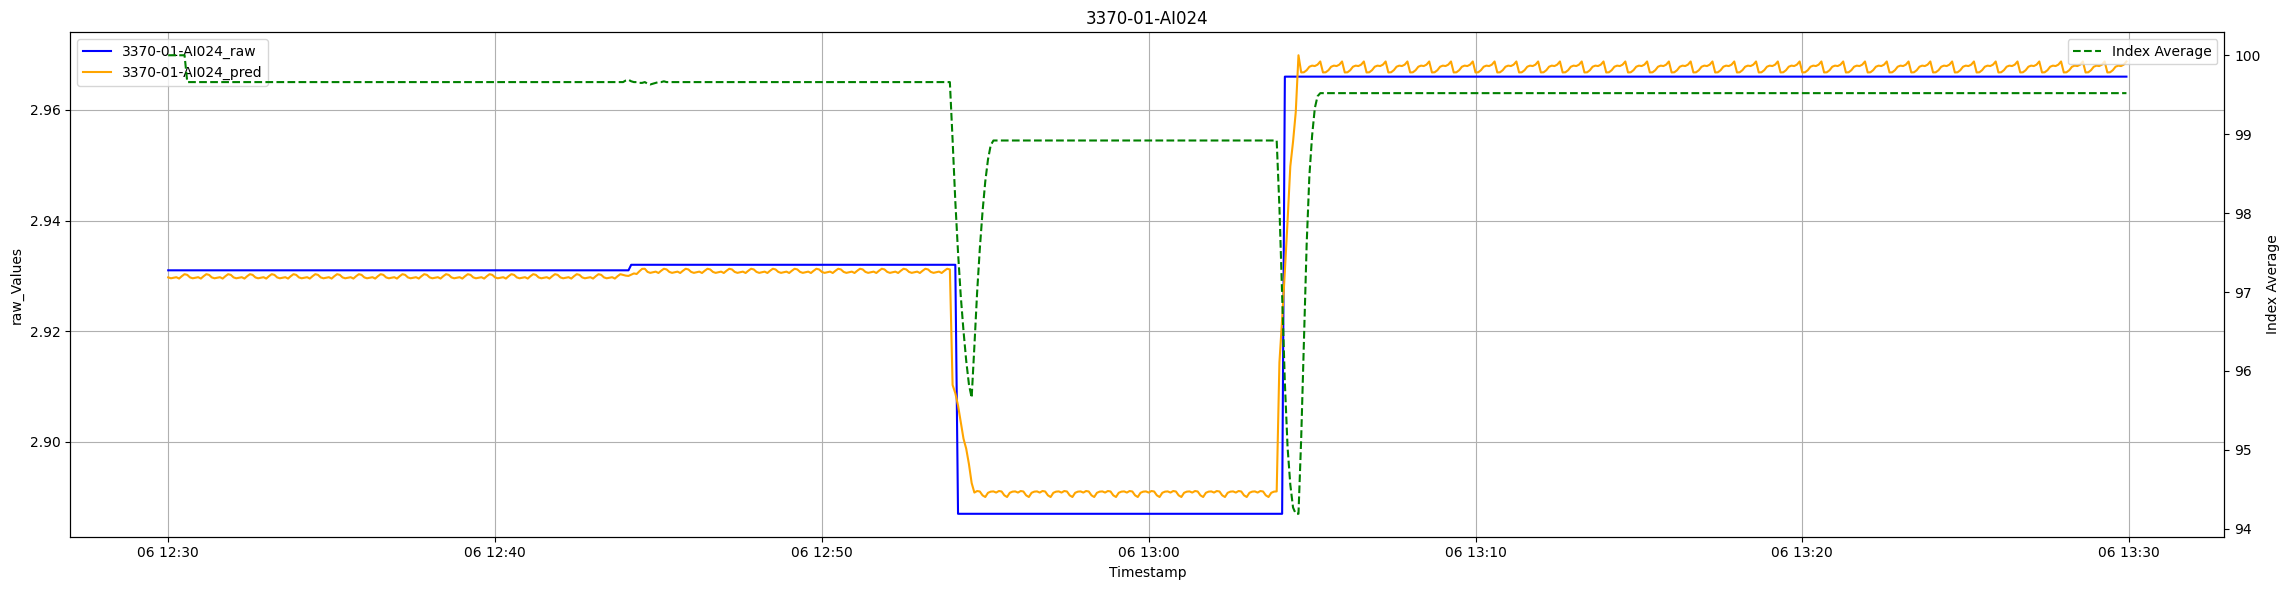

In [97]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [98]:
#테스트 순서, 사용 column지정
test_num = 10
column_num = 1
test_tag = VAE_GROUP1_TURBINE_OIL.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_OIL_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_OIL, scaler, 8, VAE_GROUP1_TURBINE_OIL.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_OIL.columns])
predicted_df.index = VAE_GROUP1_TURBINE_OIL.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_OIL[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 13ms/step


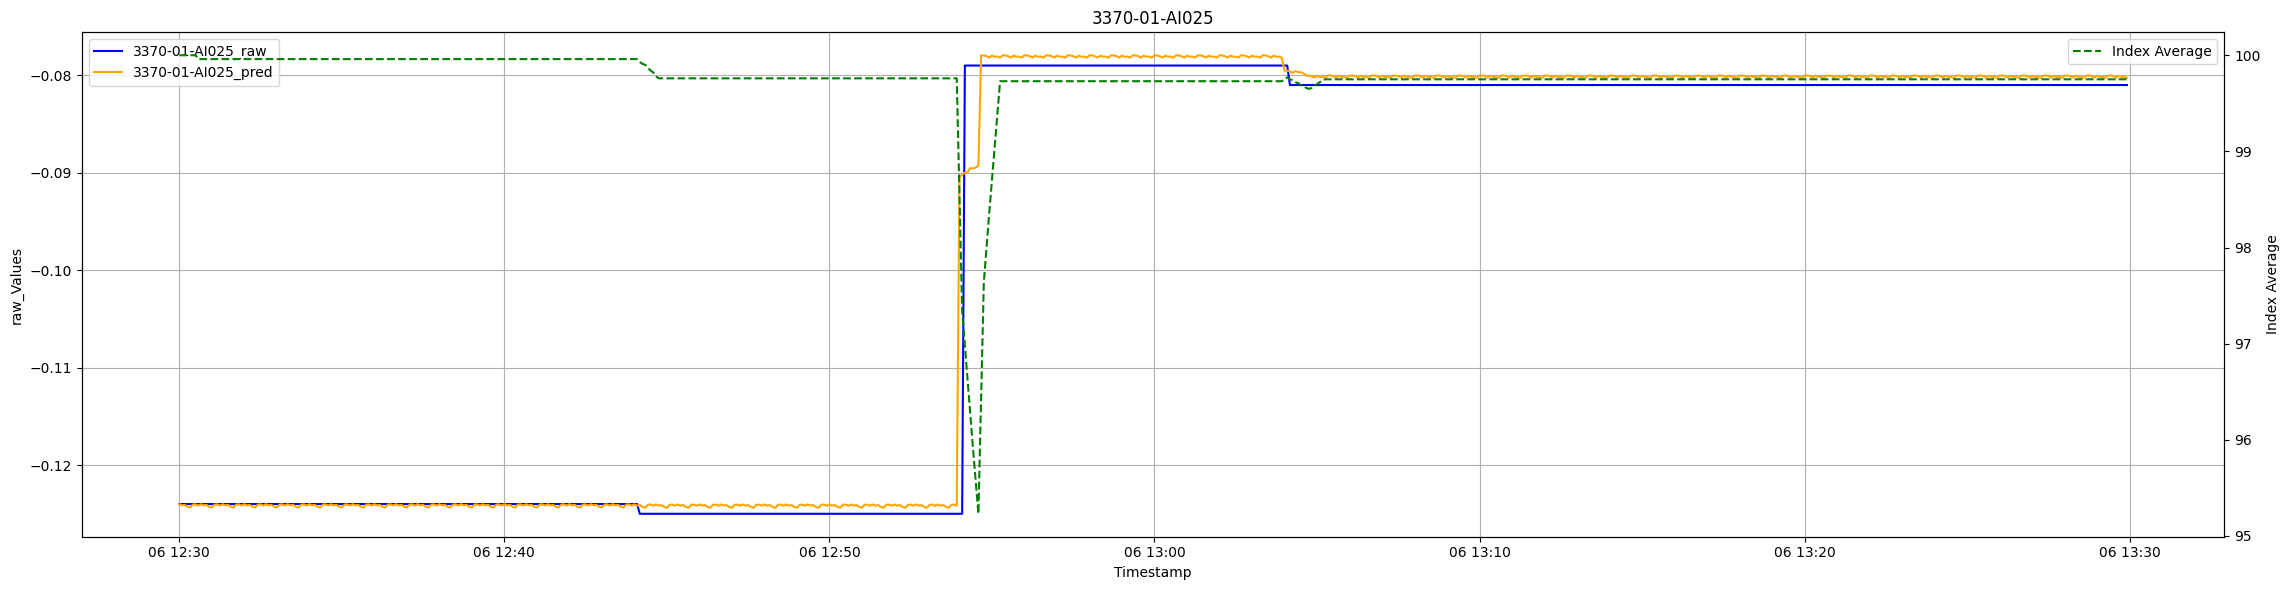

In [99]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [100]:
#테스트 순서, 사용 column지정
test_num = 11
column_num = 2
test_tag = VAE_GROUP1_TURBINE_OIL.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_OIL_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_OIL, scaler, 8, VAE_GROUP1_TURBINE_OIL.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_OIL.columns])
predicted_df.index = VAE_GROUP1_TURBINE_OIL.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_OIL[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 21ms/step


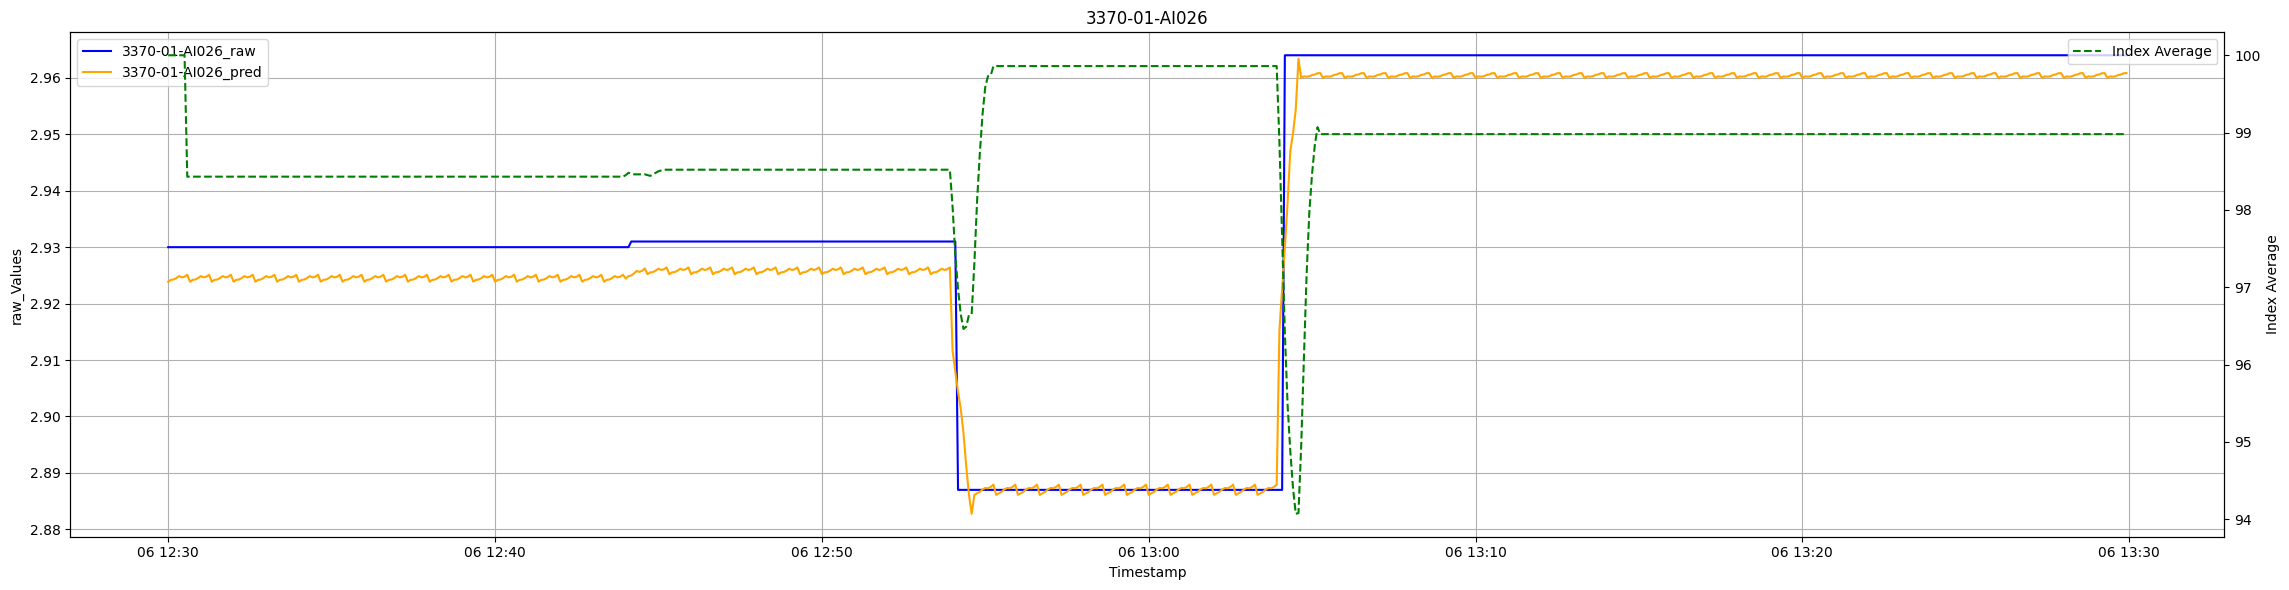

In [101]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [102]:
#테스트 순서, 사용 column지정
test_num = 12
column_num = 3
test_tag = VAE_GROUP1_TURBINE_OIL.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_OIL_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_OIL, scaler, 8, VAE_GROUP1_TURBINE_OIL.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_OIL.columns])
predicted_df.index = VAE_GROUP1_TURBINE_OIL.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_OIL[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 29ms/step


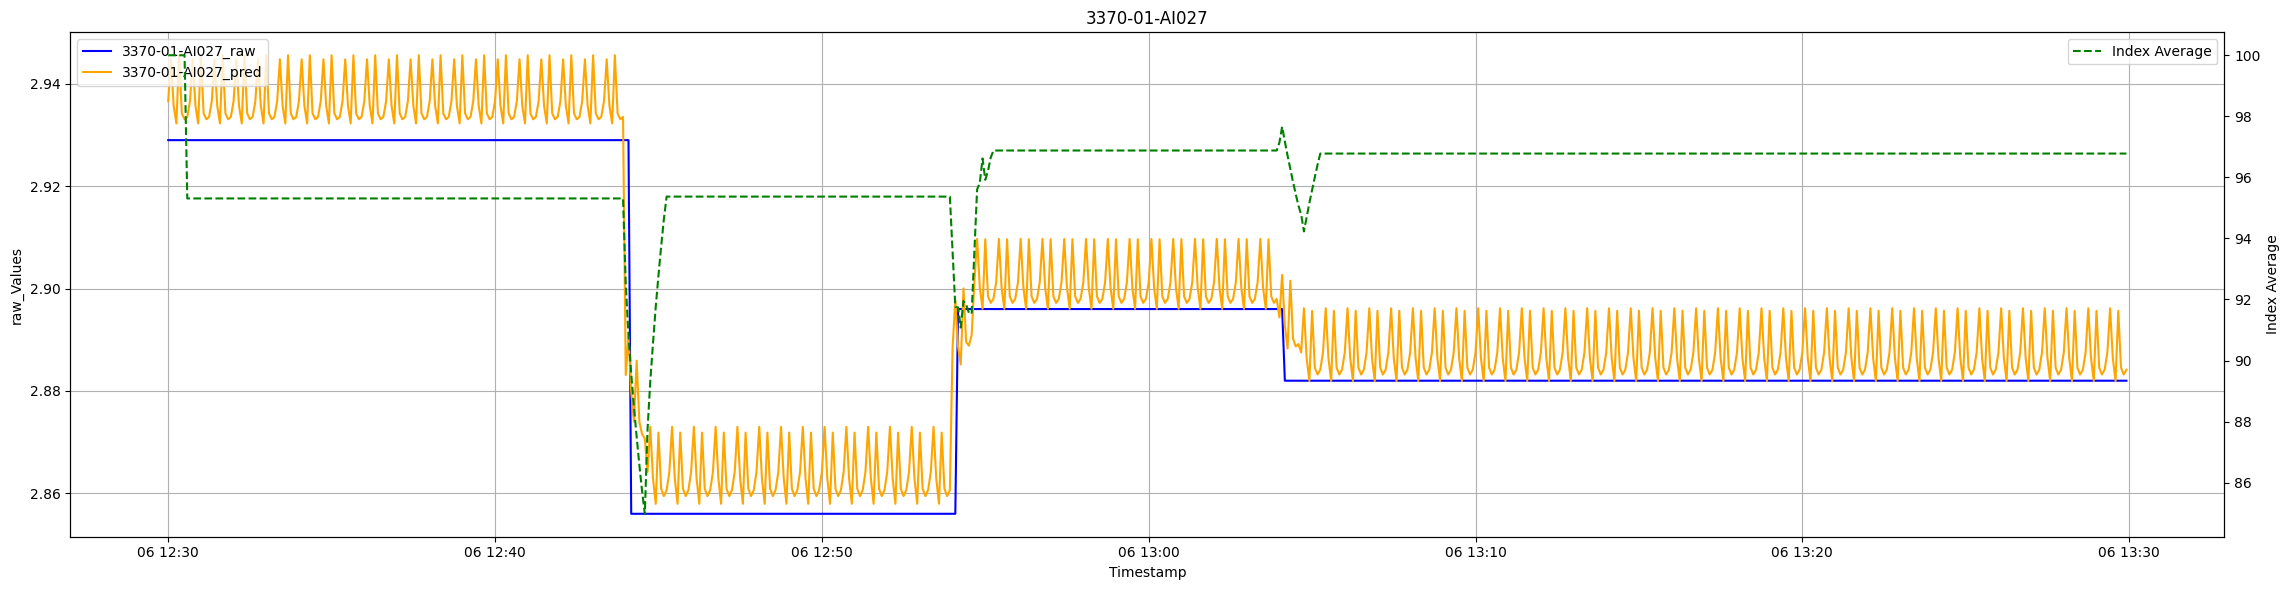

In [103]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [104]:
#테스트 순서, 사용 column지정
test_num = 13
column_num = 4
test_tag = VAE_GROUP1_TURBINE_OIL.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_OIL_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_OIL, scaler, 8, VAE_GROUP1_TURBINE_OIL.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_OIL.columns])
predicted_df.index = VAE_GROUP1_TURBINE_OIL.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_OIL[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 15ms/step


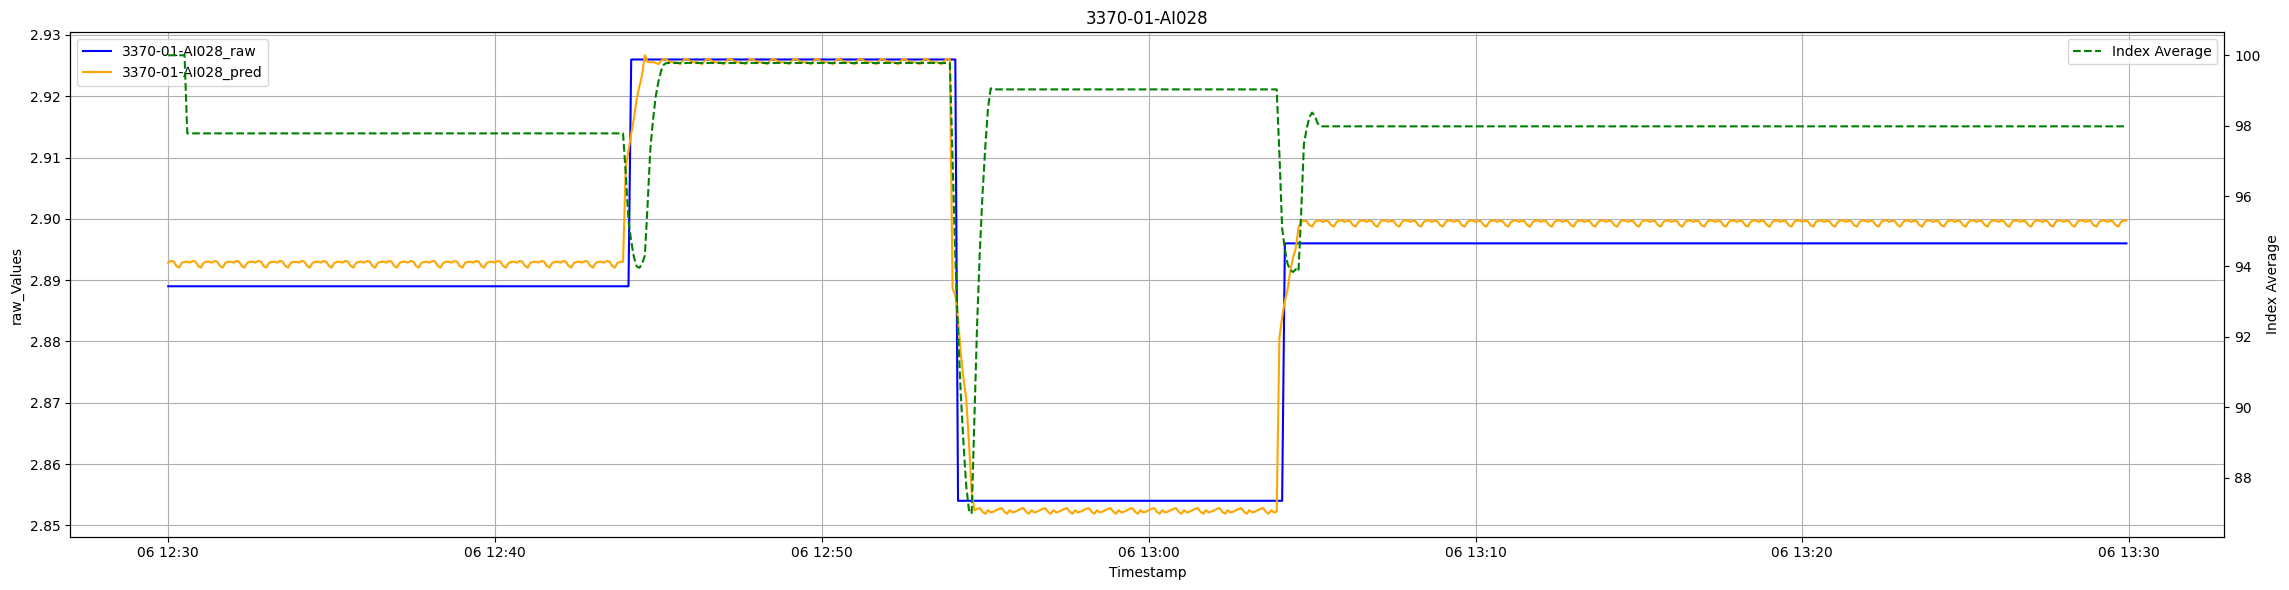

In [105]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP1_TURBINE_PRESS2

In [106]:
VAE_GROUP1_TURBINE_PRESS2 = pd.read_csv('sim/VAE_GROUP1_TURBINE_PRESS2/VAE_GROUP1_TURBINE_PRESS2.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP1_TURBINE_PRESS2.index.min(), VAE_GROUP1_TURBINE_PRESS2.index.max())
print(VAE_GROUP1_TURBINE_PRESS2.shape)
VAE_GROUP1_TURBINE_PRESS2.head(5)

2024-08-06 06:00:00 2024-08-06 07:59:55
(1440, 7)


,3370-01-AI156,3370-01-AI153,3370-01-AI109,3370-01-AI110,3370-01-EBB08,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,,
2024-08-06 06:00:00,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:05,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:10,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:15,9.202,8.023,51.759,53.018,9.202,0.0,0.0
2024-08-06 06:00:20,9.202,8.023,51.759,53.018,9.202,0.0,0.0


In [107]:
#테스트 순서, 사용 column지정
test_num = 14
column_num = 2
test_tag = VAE_GROUP1_TURBINE_PRESS2.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_PRESS2'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_PRESS2, scaler, 8, VAE_GROUP1_TURBINE_PRESS2.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_PRESS2.columns])
predicted_df.index = VAE_GROUP1_TURBINE_PRESS2.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_PRESS2[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

6/6 [==============================] - 0s 16ms/step


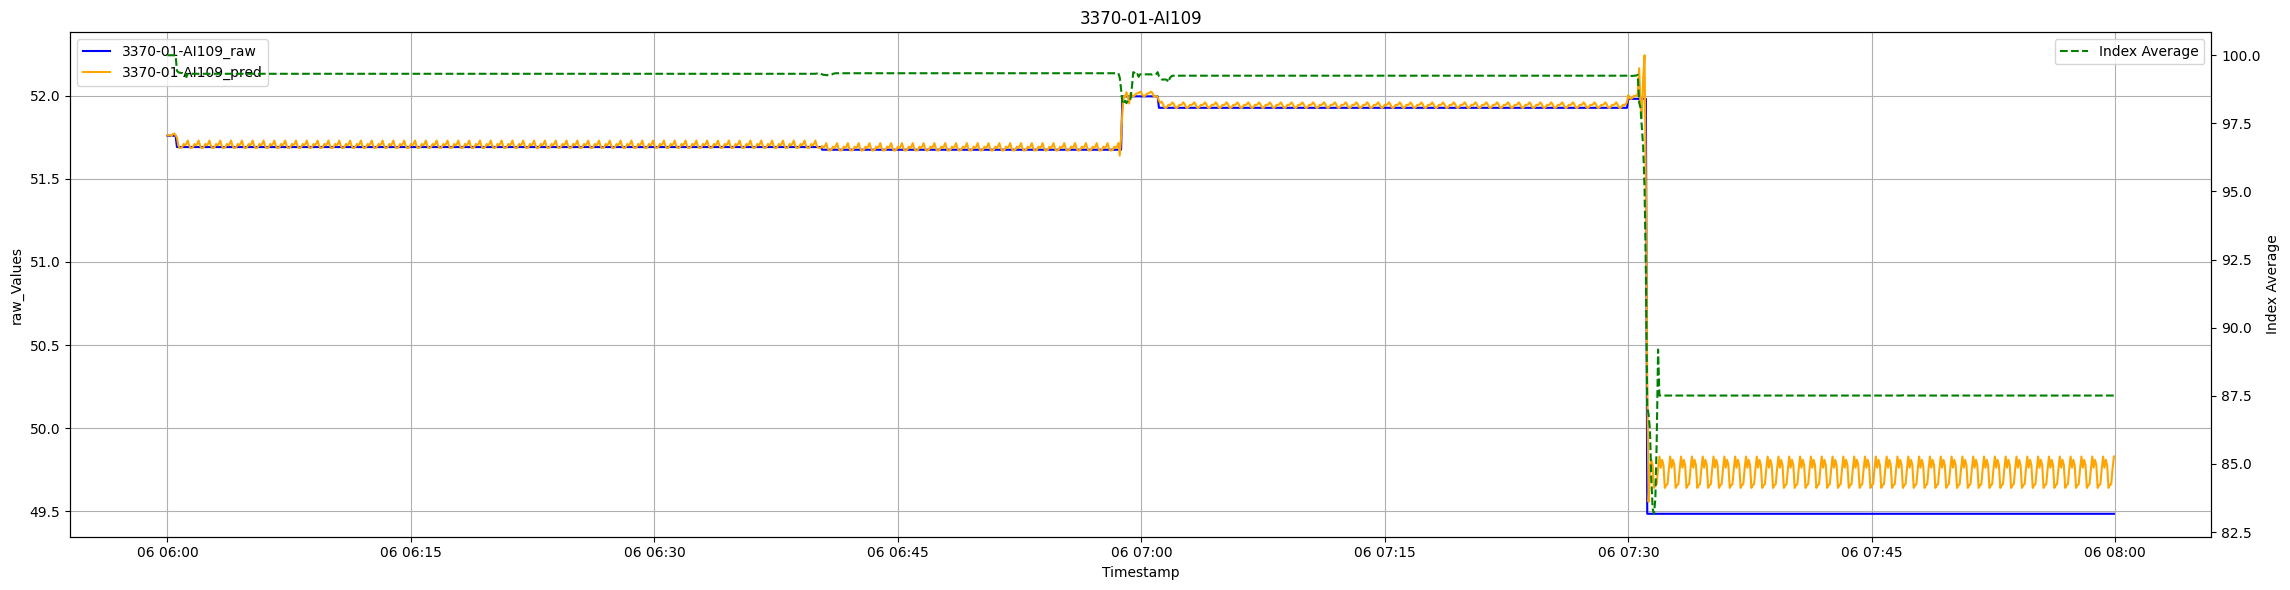

In [108]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [109]:
#테스트 순서, 사용 column지정
test_num = 15
column_num = 3
test_tag = VAE_GROUP1_TURBINE_PRESS2.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP1_TURBINE_PRESS2'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP1_TURBINE_PRESS2, scaler, 8, VAE_GROUP1_TURBINE_PRESS2.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP1_TURBINE_PRESS2.columns])
predicted_df.index = VAE_GROUP1_TURBINE_PRESS2.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP1_TURBINE_PRESS2[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

6/6 [==============================] - 0s 15ms/step


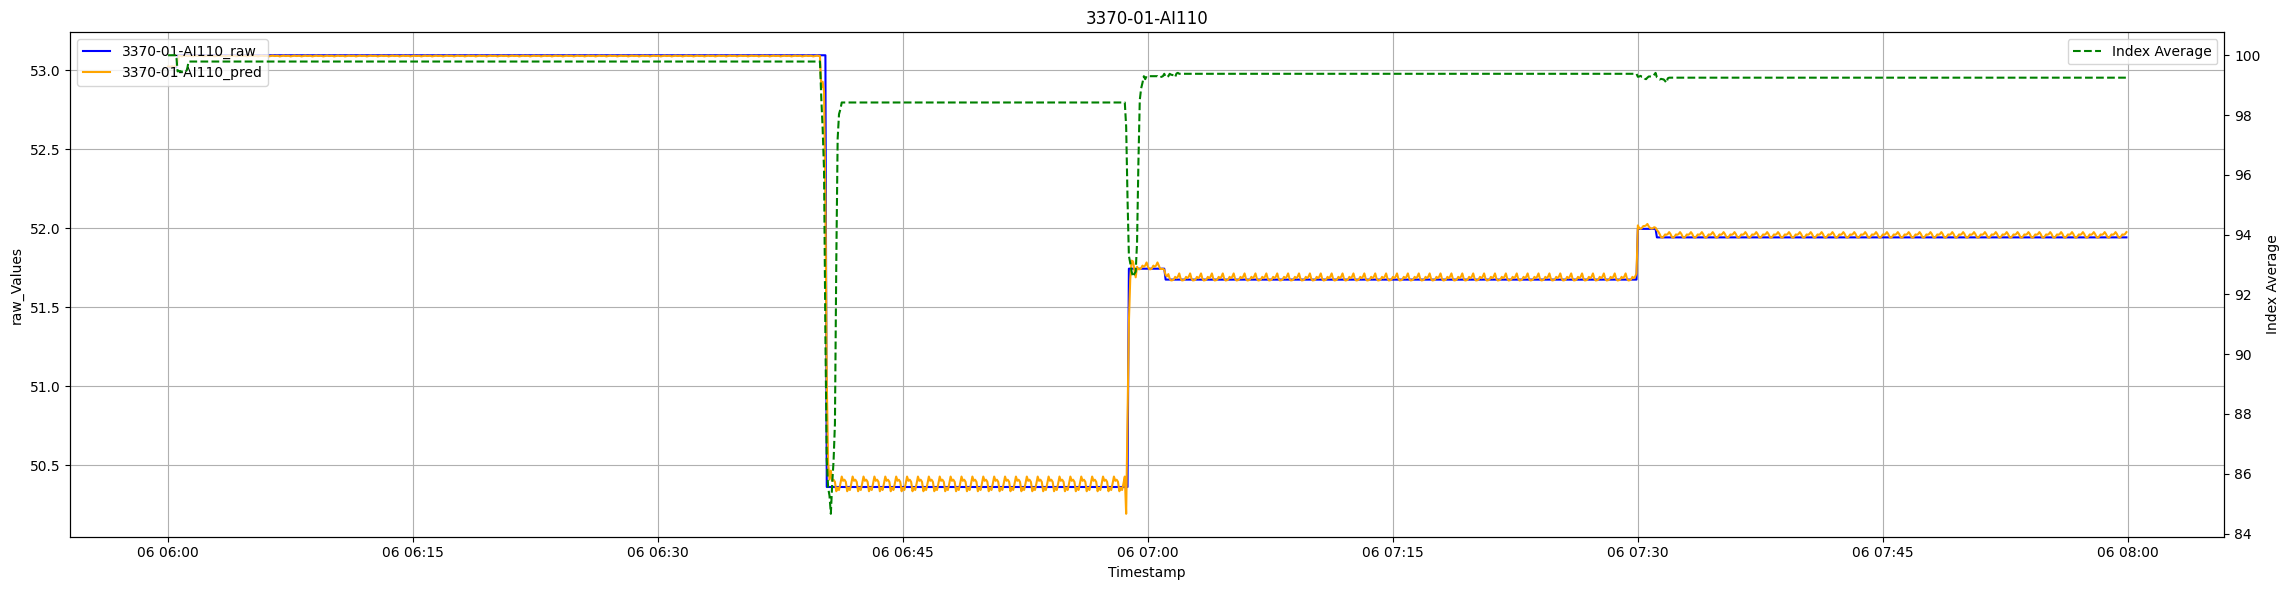

In [110]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP2_SS_PRESS1

In [111]:
VAE_GROUP2_SS_PRESS1 = pd.read_csv('sim/VAE_GROUP2_SS_PRESS1/VAE_GROUP2_SS_PRESS1.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP2_SS_PRESS1.index.min(), VAE_GROUP2_SS_PRESS1.index.max())
print(VAE_GROUP2_SS_PRESS1.shape)
VAE_GROUP2_SS_PRESS1.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 6)


,3370-02-AI035,3370-02-AI036,3370-02-AI037,3370-02-AI145,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,
2024-08-06 12:30:00,1.327,1.331,1.263,9.938,1.0,1.0
2024-08-06 12:30:05,1.327,1.331,1.263,9.938,1.0,1.0
2024-08-06 12:30:10,1.327,1.331,1.263,9.938,1.0,1.0
2024-08-06 12:30:15,1.327,1.331,1.263,9.938,1.0,1.0
2024-08-06 12:30:20,1.327,1.331,1.263,9.938,1.0,1.0


In [112]:
#테스트 순서, 사용 column지정
test_num = 16
column_num = 0
test_tag = VAE_GROUP2_SS_PRESS1.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP2_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP2_SS_PRESS1, scaler, 8, VAE_GROUP2_SS_PRESS1.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP2_SS_PRESS1.columns])
predicted_df.index = VAE_GROUP2_SS_PRESS1.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP2_SS_PRESS1[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 34ms/step


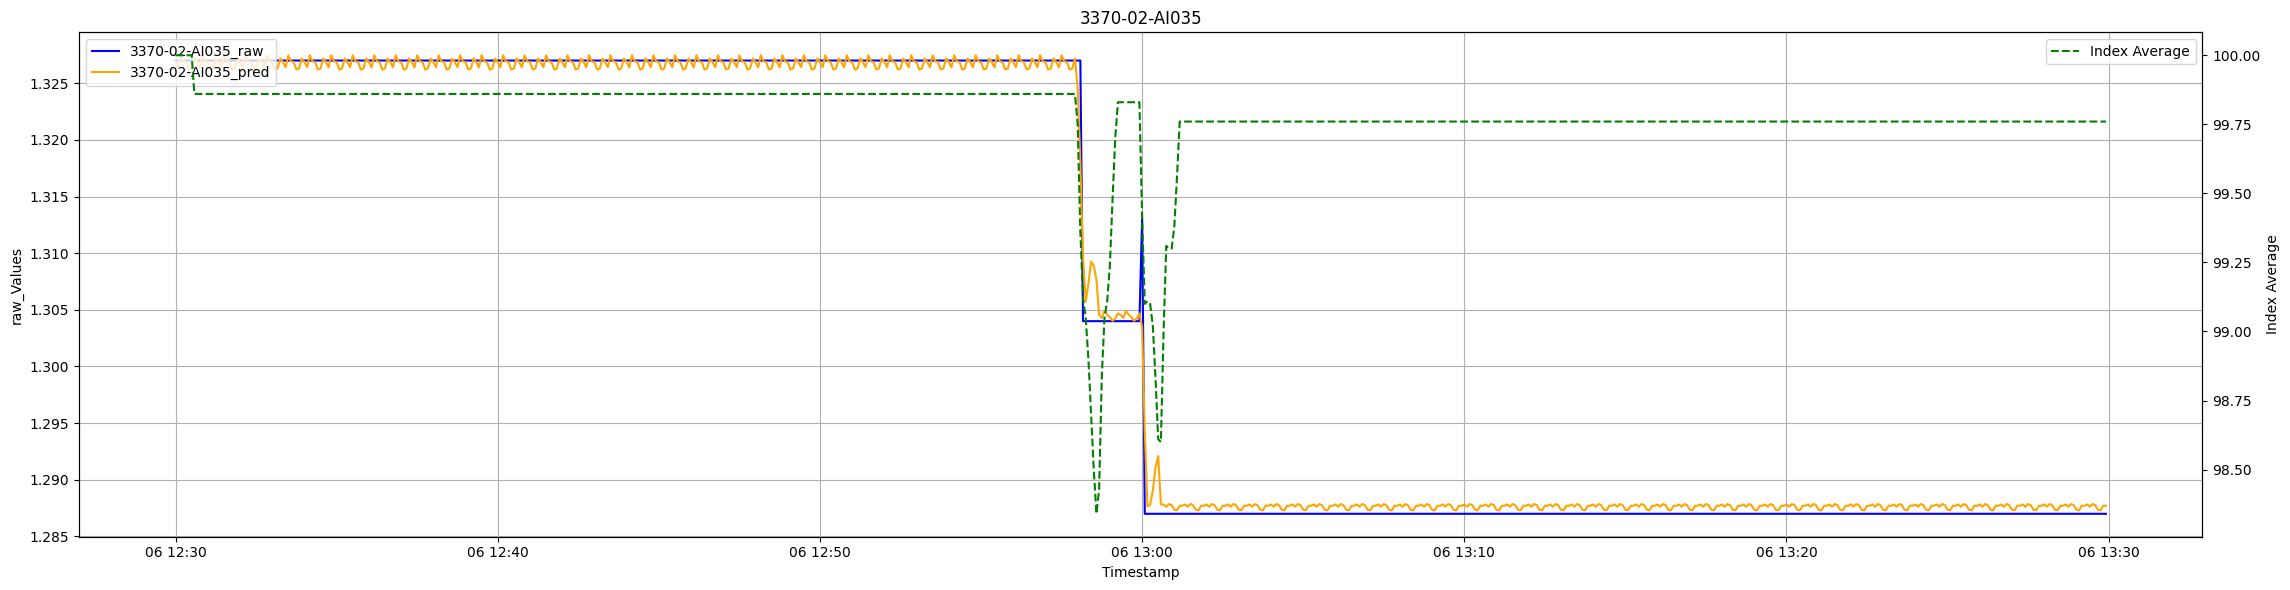

In [113]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [114]:
#테스트 순서, 사용 column지정
test_num = 17
column_num = 1
test_tag = VAE_GROUP2_SS_PRESS1.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP2_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP2_SS_PRESS1, scaler, 8, VAE_GROUP2_SS_PRESS1.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP2_SS_PRESS1.columns])
predicted_df.index = VAE_GROUP2_SS_PRESS1.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP2_SS_PRESS1[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 25ms/step


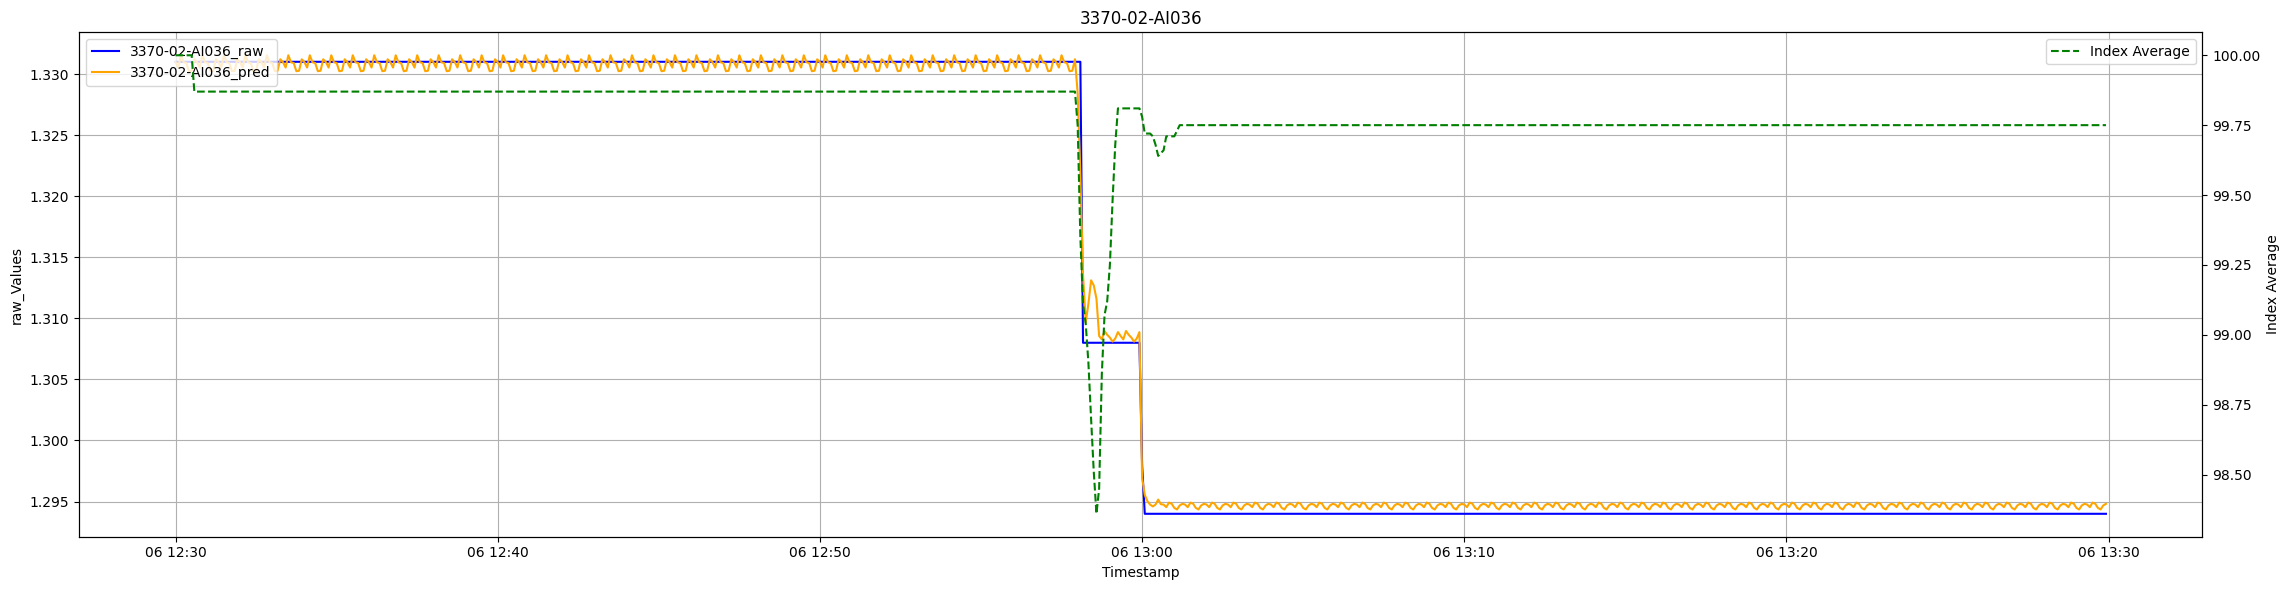

In [115]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [116]:
#테스트 순서, 사용 column지정
test_num = 18
column_num = 2
test_tag = VAE_GROUP2_SS_PRESS1.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP2_SS_PRESS1_'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP2_SS_PRESS1, scaler, 8, VAE_GROUP2_SS_PRESS1.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP2_SS_PRESS1.columns])
predicted_df.index = VAE_GROUP2_SS_PRESS1.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP2_SS_PRESS1[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 16ms/step


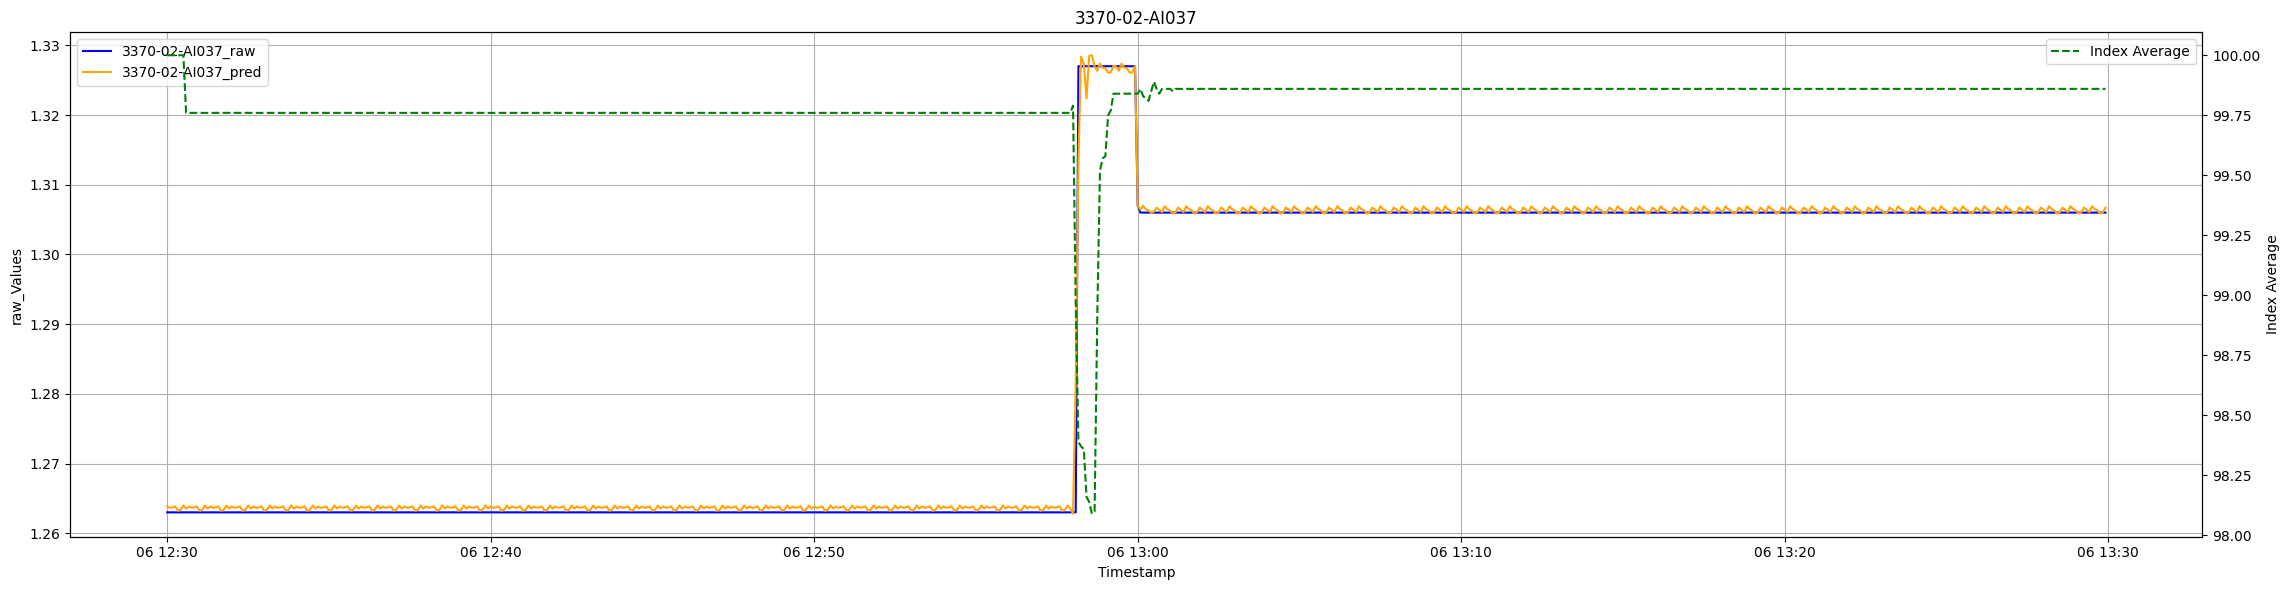

In [117]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

#### 시료1 VAE_GROUP2_SS_TEMP

In [118]:
VAE_GROUP2_SS_TEMP = pd.read_csv('sim/VAE_GROUP2_SS_TEMP/VAE_GROUP2_SS_TEMP.csv', parse_dates=['Timestamp'], index_col='Timestamp')
print(VAE_GROUP2_SS_TEMP.index.min(), VAE_GROUP2_SS_TEMP.index.max())
print(VAE_GROUP2_SS_TEMP.shape)
VAE_GROUP2_SS_TEMP.head(5)

2024-08-06 12:30:00 2024-08-06 13:29:55
(720, 7)


,3370-02-AI060,3370-02-AI060-1,3370-02-AI061,3370-02-AI061-1,3370-02-AI062,3370-01-G-MODE,3370-01-P-MODE
Timestamp,,,,,,,
2024-08-06 12:30:00,28.177,0.378,28.681,29.312,28.681,1,1
2024-08-06 12:30:05,28.177,0.378,28.681,29.312,28.681,1,1
2024-08-06 12:30:10,28.177,0.378,28.681,29.312,28.681,1,1
2024-08-06 12:30:15,28.177,0.378,28.681,29.312,28.681,1,1
2024-08-06 12:30:20,28.177,0.378,28.681,29.312,28.681,1,1


In [119]:
#테스트 순서, 사용 column지정
test_num = 19
column_num = 0
test_tag = VAE_GROUP2_SS_TEMP.columns[column_num]

# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP2_SS_TEMP'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP2_SS_TEMP, scaler, 8, VAE_GROUP2_SS_TEMP.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP2_SS_TEMP.columns])
predicted_df.index = VAE_GROUP2_SS_TEMP.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP2_SS_TEMP[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 31ms/step


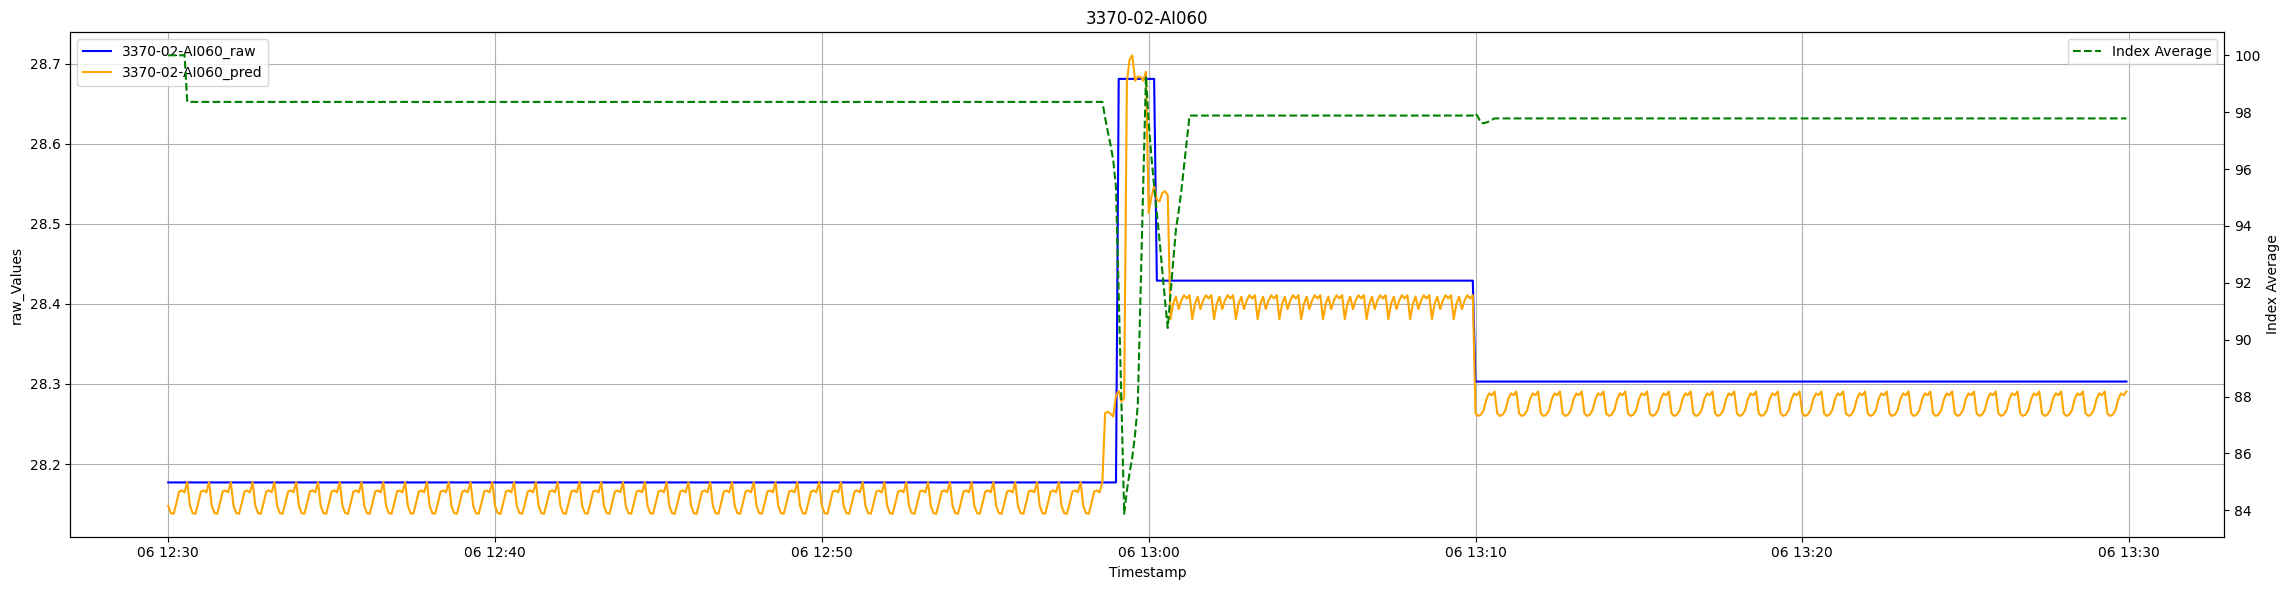

In [120]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()

In [121]:
#테스트 순서, 사용 column지정
test_num = 20
column_num = 2
test_tag = VAE_GROUP2_SS_TEMP.columns[column_num]


# 모델 및 스케일러 불러오기
model_name = 'VAE_GROUP2_SS_TEMP'
model, scaler = load_model_and_scaler(model_name, scalers)

# 데이터 전처리
reshaped_data = preprocess_data(VAE_GROUP2_SS_TEMP, scaler, 8, VAE_GROUP2_SS_TEMP.shape[1])

# 모델 예측
predictions = model.predict(reshaped_data)

# 스케일러로 변환된 데이터 복구
inverse_predictions = inverse_transform_predictions(predictions, scaler)

# DataFrame으로 변환 후 기존 index로 변경
predicted_df = pd.DataFrame(inverse_predictions, columns=[f"{col}_pred" for col in VAE_GROUP2_SS_TEMP.columns])
predicted_df.index = VAE_GROUP2_SS_TEMP.index

# Threshold 가져오기
threshold = info[info['tag_name'] == test_tag]['threshold'].values[0]

# 결과 계산
result = pd.concat([VAE_GROUP2_SS_TEMP[test_tag], predicted_df[f'{test_tag}_pred']], axis=1)
result = calculate_index(result, threshold)
# result.to_csv(f'result/{model_name}_result{test_num}.csv')

3/3 [==============================] - 0s 15ms/step


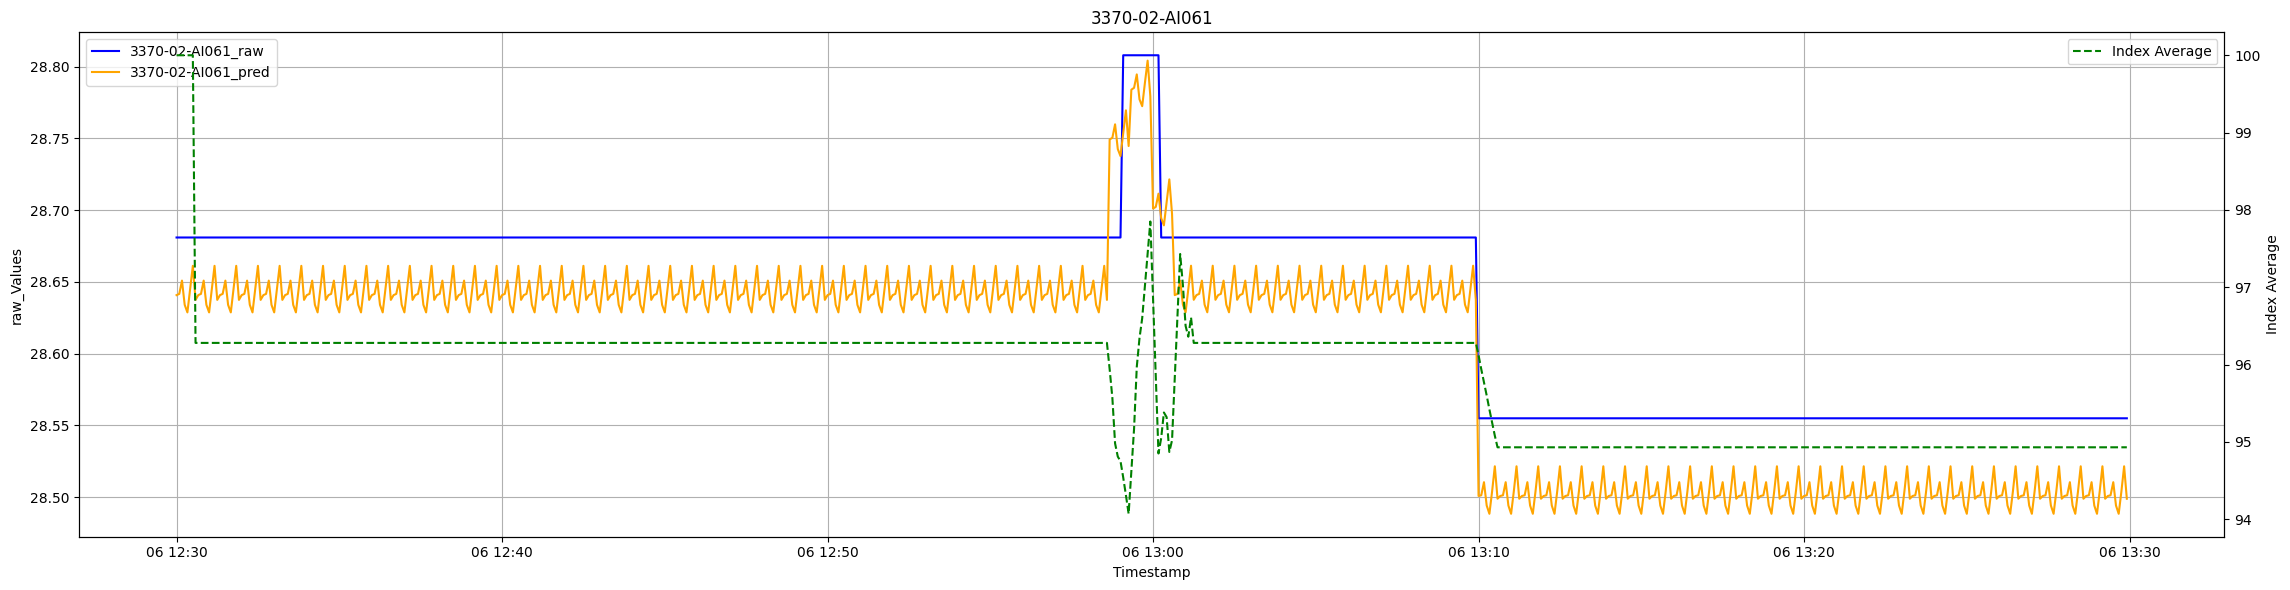

In [122]:
plt.figure(figsize=(23,6))
plt.plot(result[test_tag], label=f'{test_tag}_raw', color='blue')
plt.plot(result[f'{test_tag}_pred'], label=f'{test_tag}_pred', color='orange')

# 첫 번째 y축 설정
plt.title(test_tag)
plt.xlabel('Timestamp')
plt.ylabel('raw_Values')
plt.legend(loc='upper left')
plt.grid()

# 두 번째 y축 설정
ax2 = plt.gca().twinx()
ax2.plot(result['index_average'], label='Index Average', color='green', linestyle='--')
ax2.set_ylabel('Index Average')

# 두 번째 y축 레전드와 설정
ax2.legend(loc='upper right')

# 레이아웃 조정 및 표시
if result['alarm'].any():
    alarm_index = result[result['alarm']==True].index[0]
    plt.axvline(alarm_index, color='red', linestyle='--') 
    plt.text(alarm_index, 60, alarm_index, color='red', fontsize=12, ha='center') 
    plt.axhline(70, color='red')
    
plt.tight_layout()
plt.show()